In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
from scipy.optimize import curve_fit
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from StimulusnResponse import expSnR

importing Jupyter notebook from StimulusnResponse.ipynb


In [3]:
def ensure_dir(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)

In [4]:
def NGD2L_TK_AS(T, epsilon, gamma, omegastar, deltastar, tau_y, Dmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kw = -Dmp*( 1/np.cos(deltastar)*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar) -np.exp(-gamma*T) )
    w = np.convolve(x, Kw, 'full')[:len(T):50]*dt
    return w/(dt)

In [5]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

In [6]:
figmap = [[np.nan, 7,15,23,31,39,47,np.nan],
          [     1, 8,16,24,32,40,48,    55],
          [     2, 9,17,25,33,41,49,    56],
          [     3,10,18,26,34,42,50,    57],
          [     4,11,19,27,35,43,51,    58],
          [     5,12,20,28,36,44,52,    59],
          [     6,13,21,29,37,45,53,    60],
          [np.nan,14,22,30,38,46,54,np.nan]]
figmap = np.array(figmap)
XOsave = False

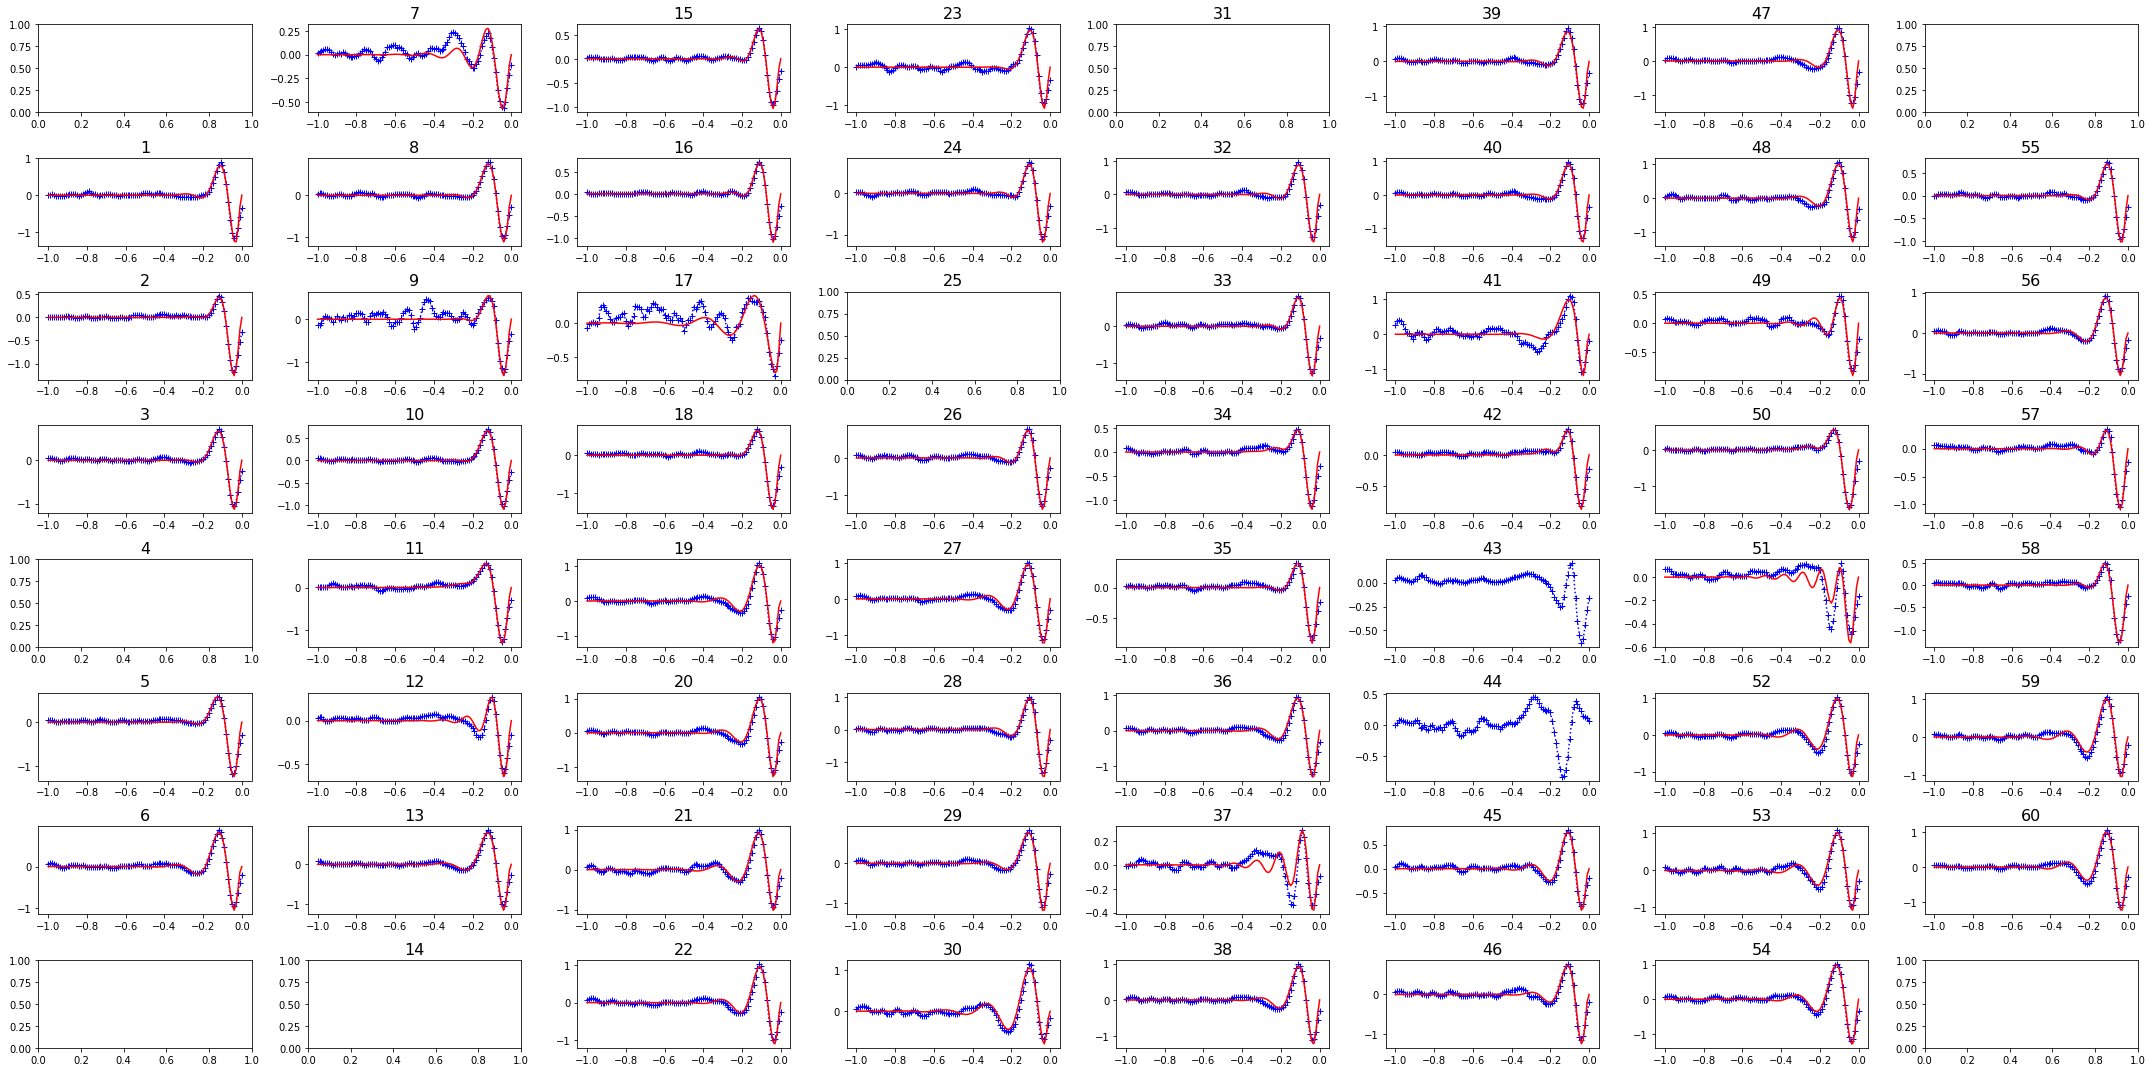

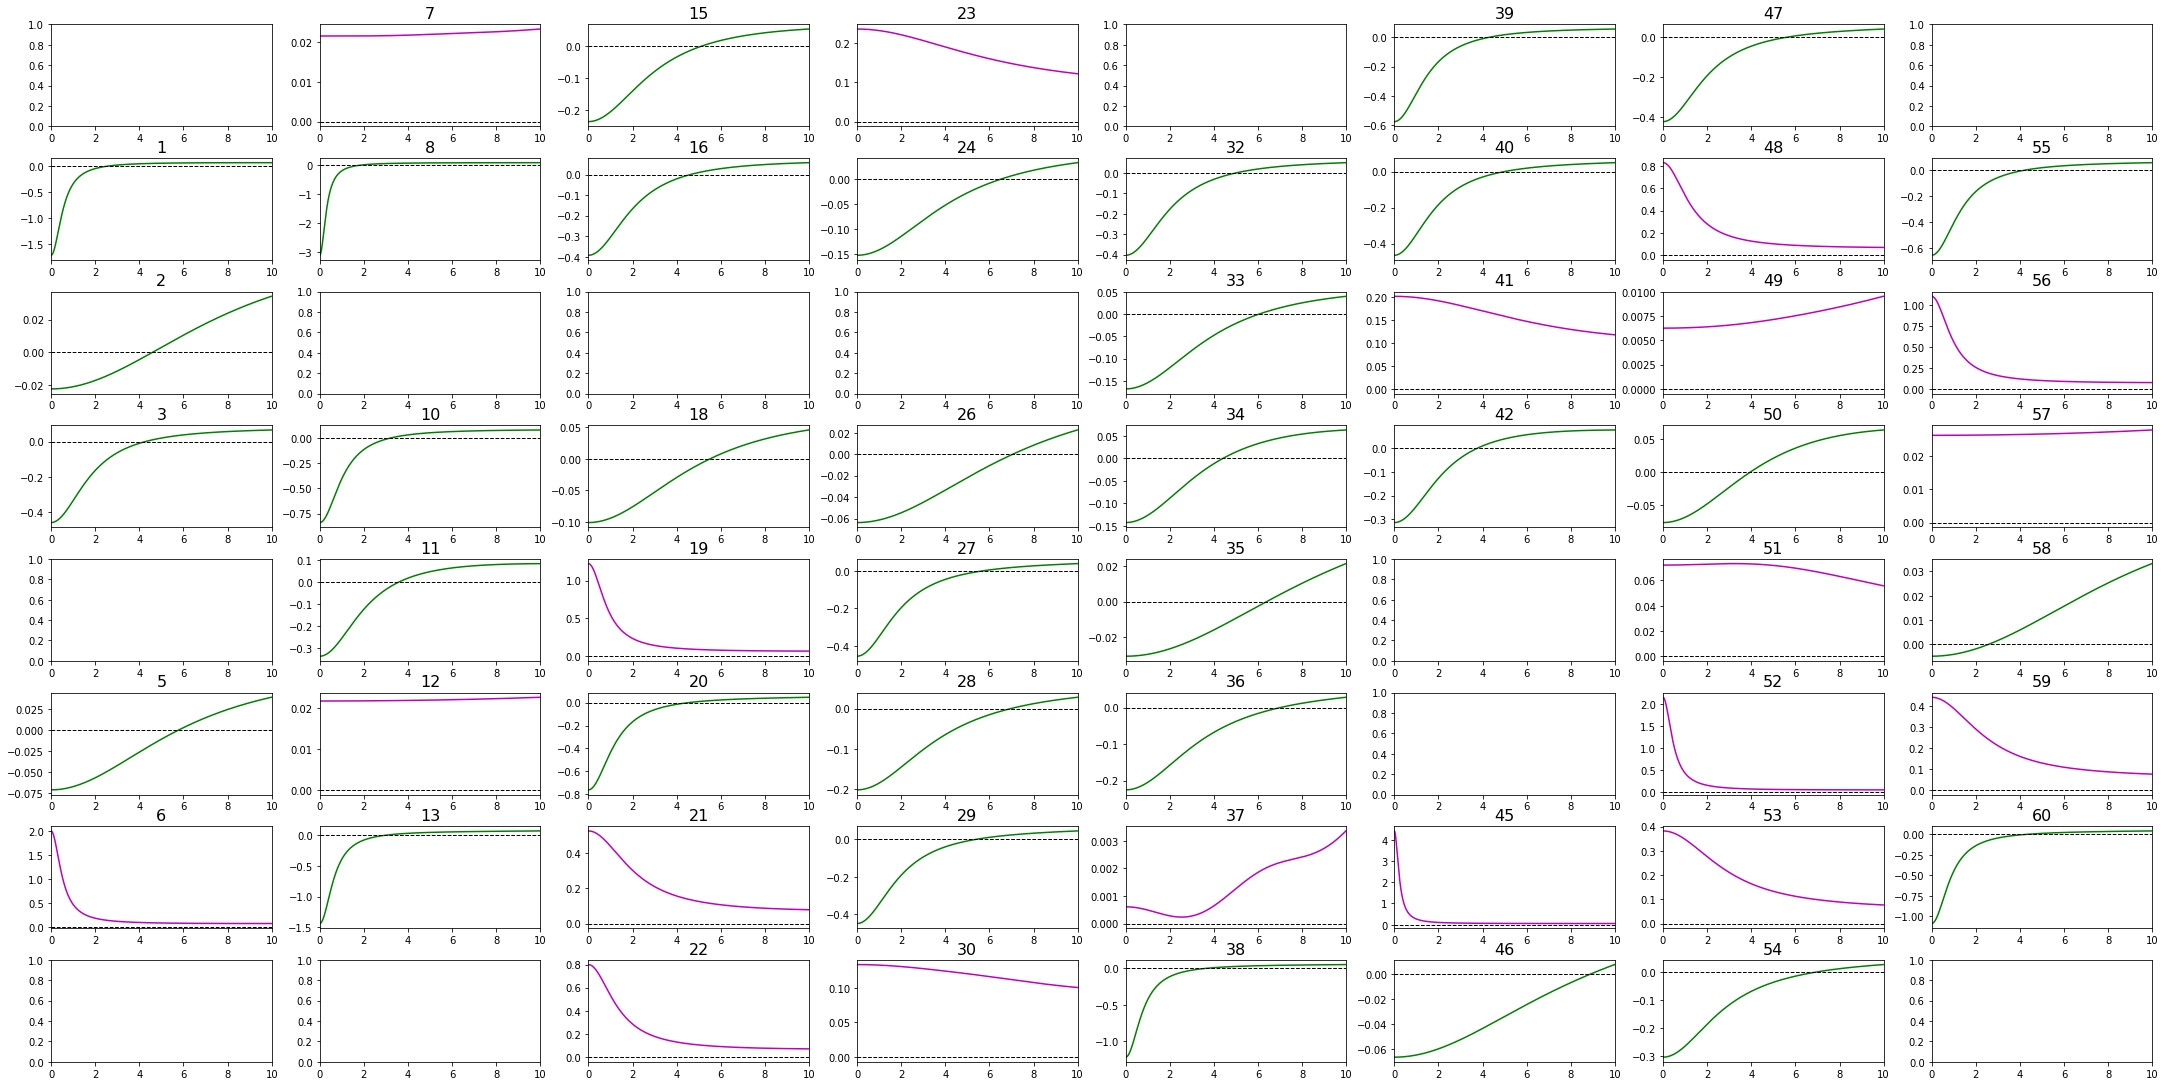

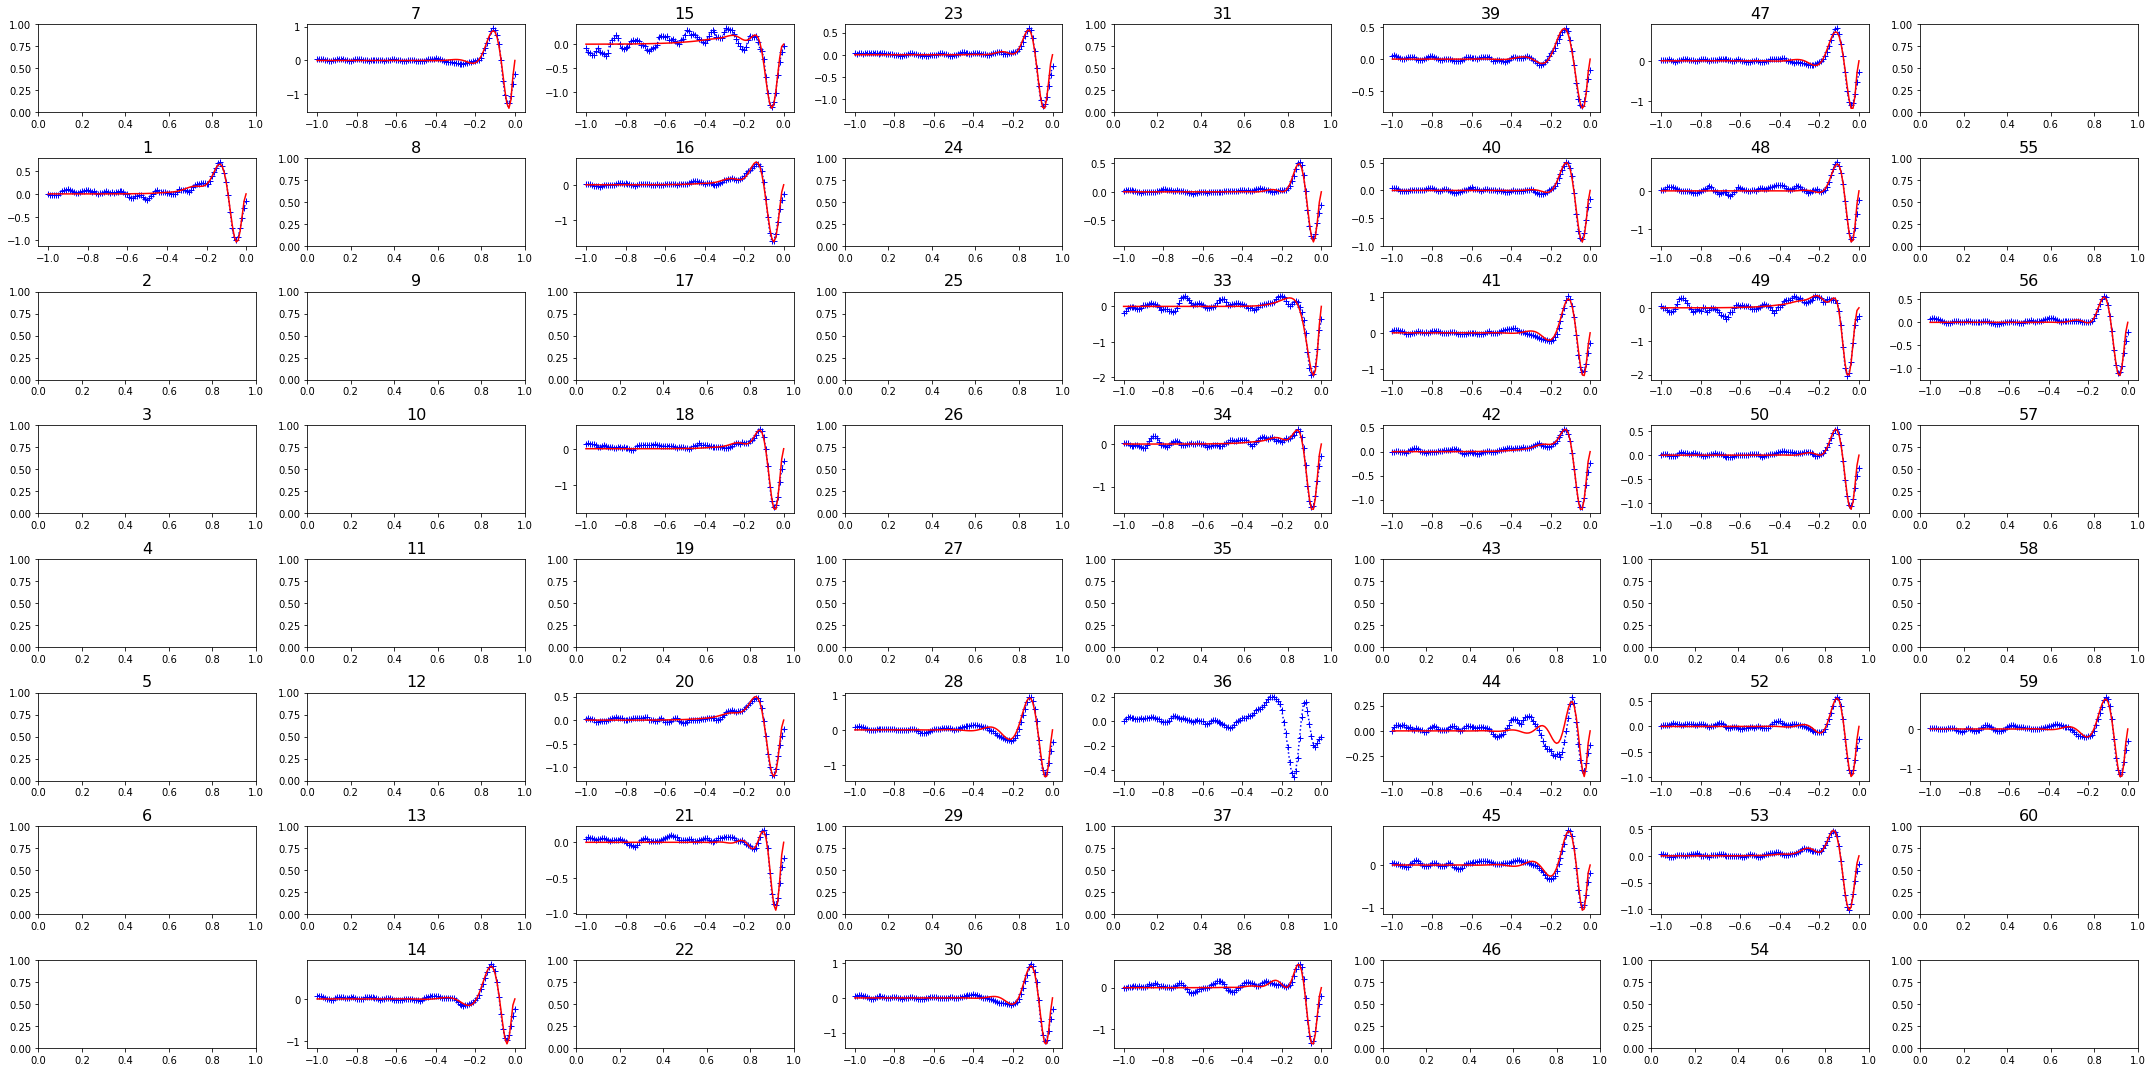

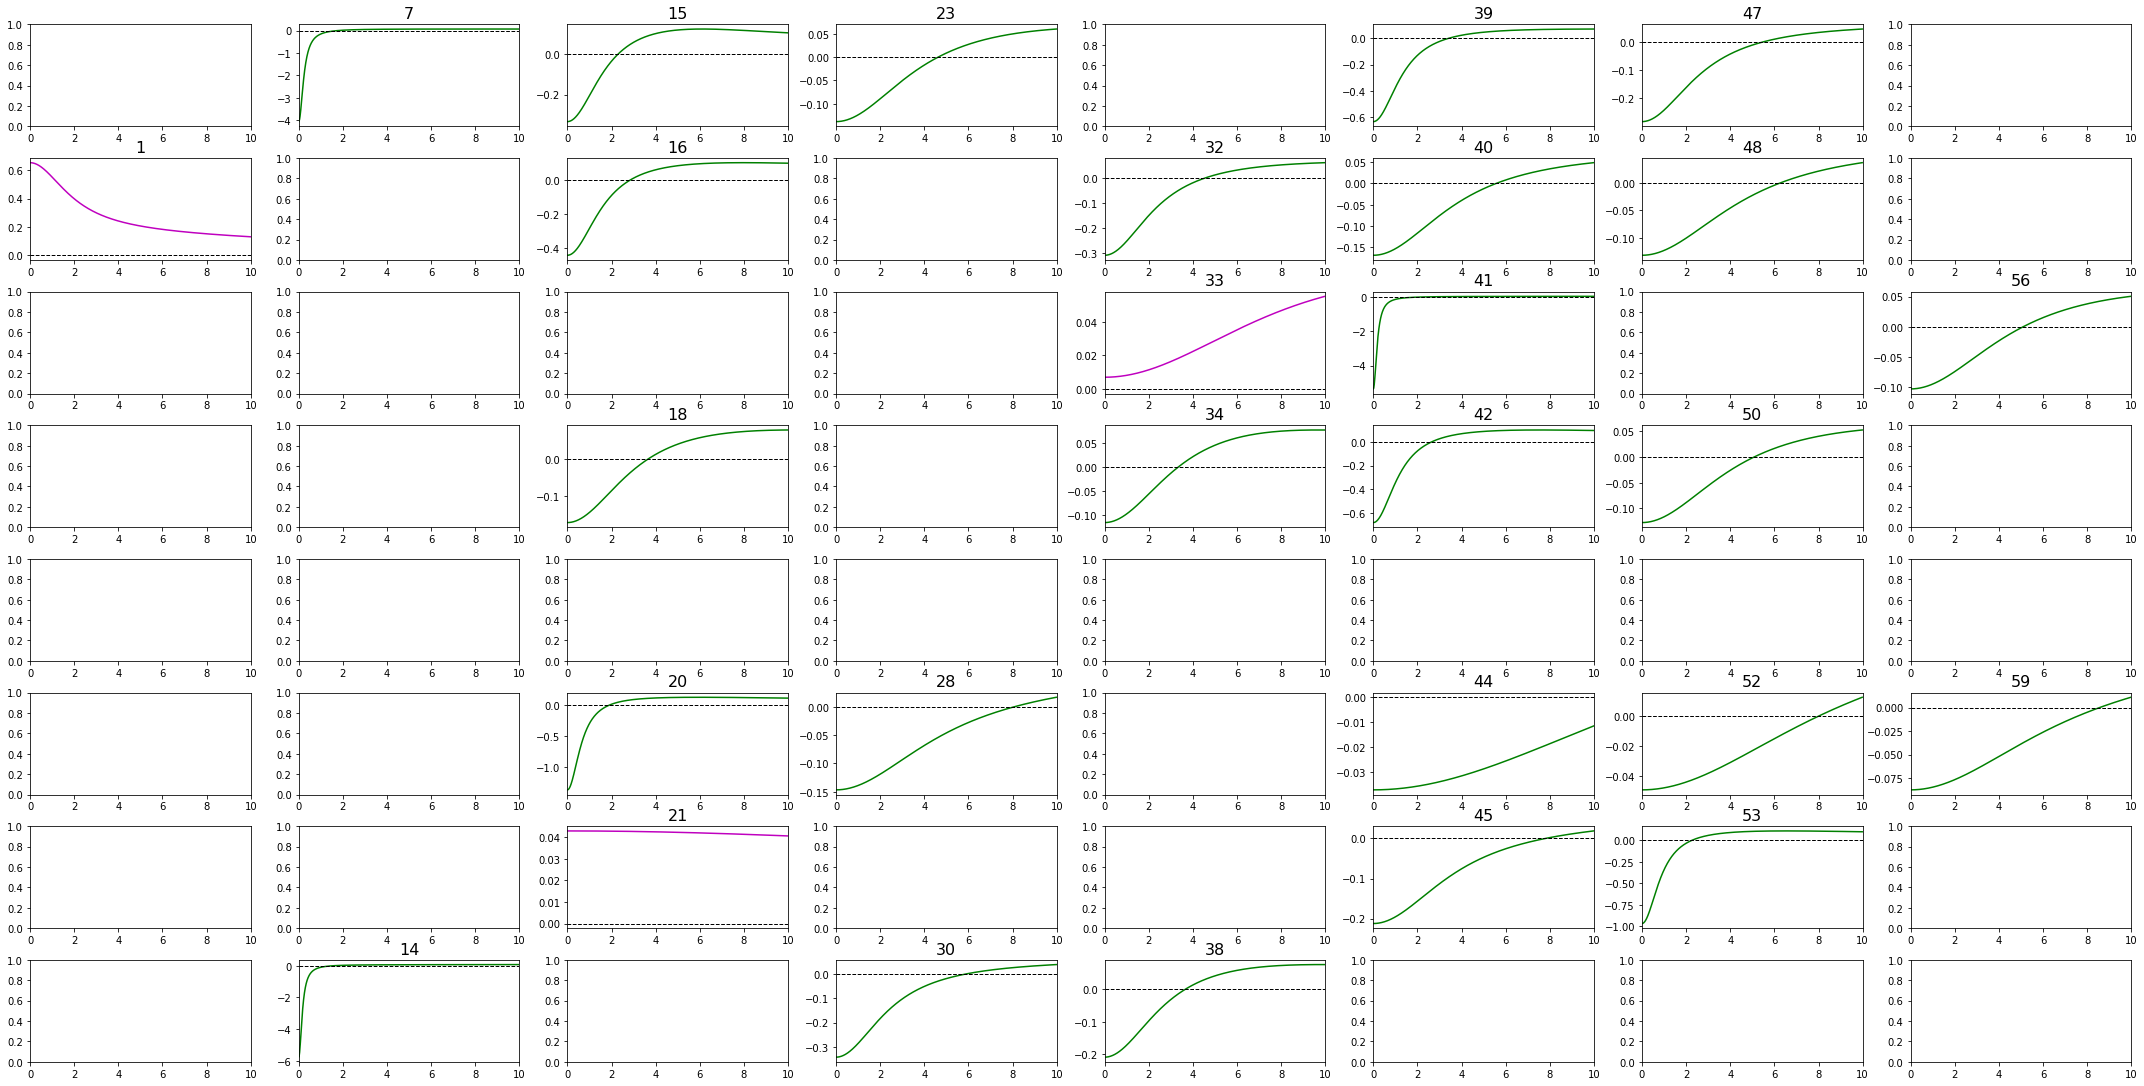

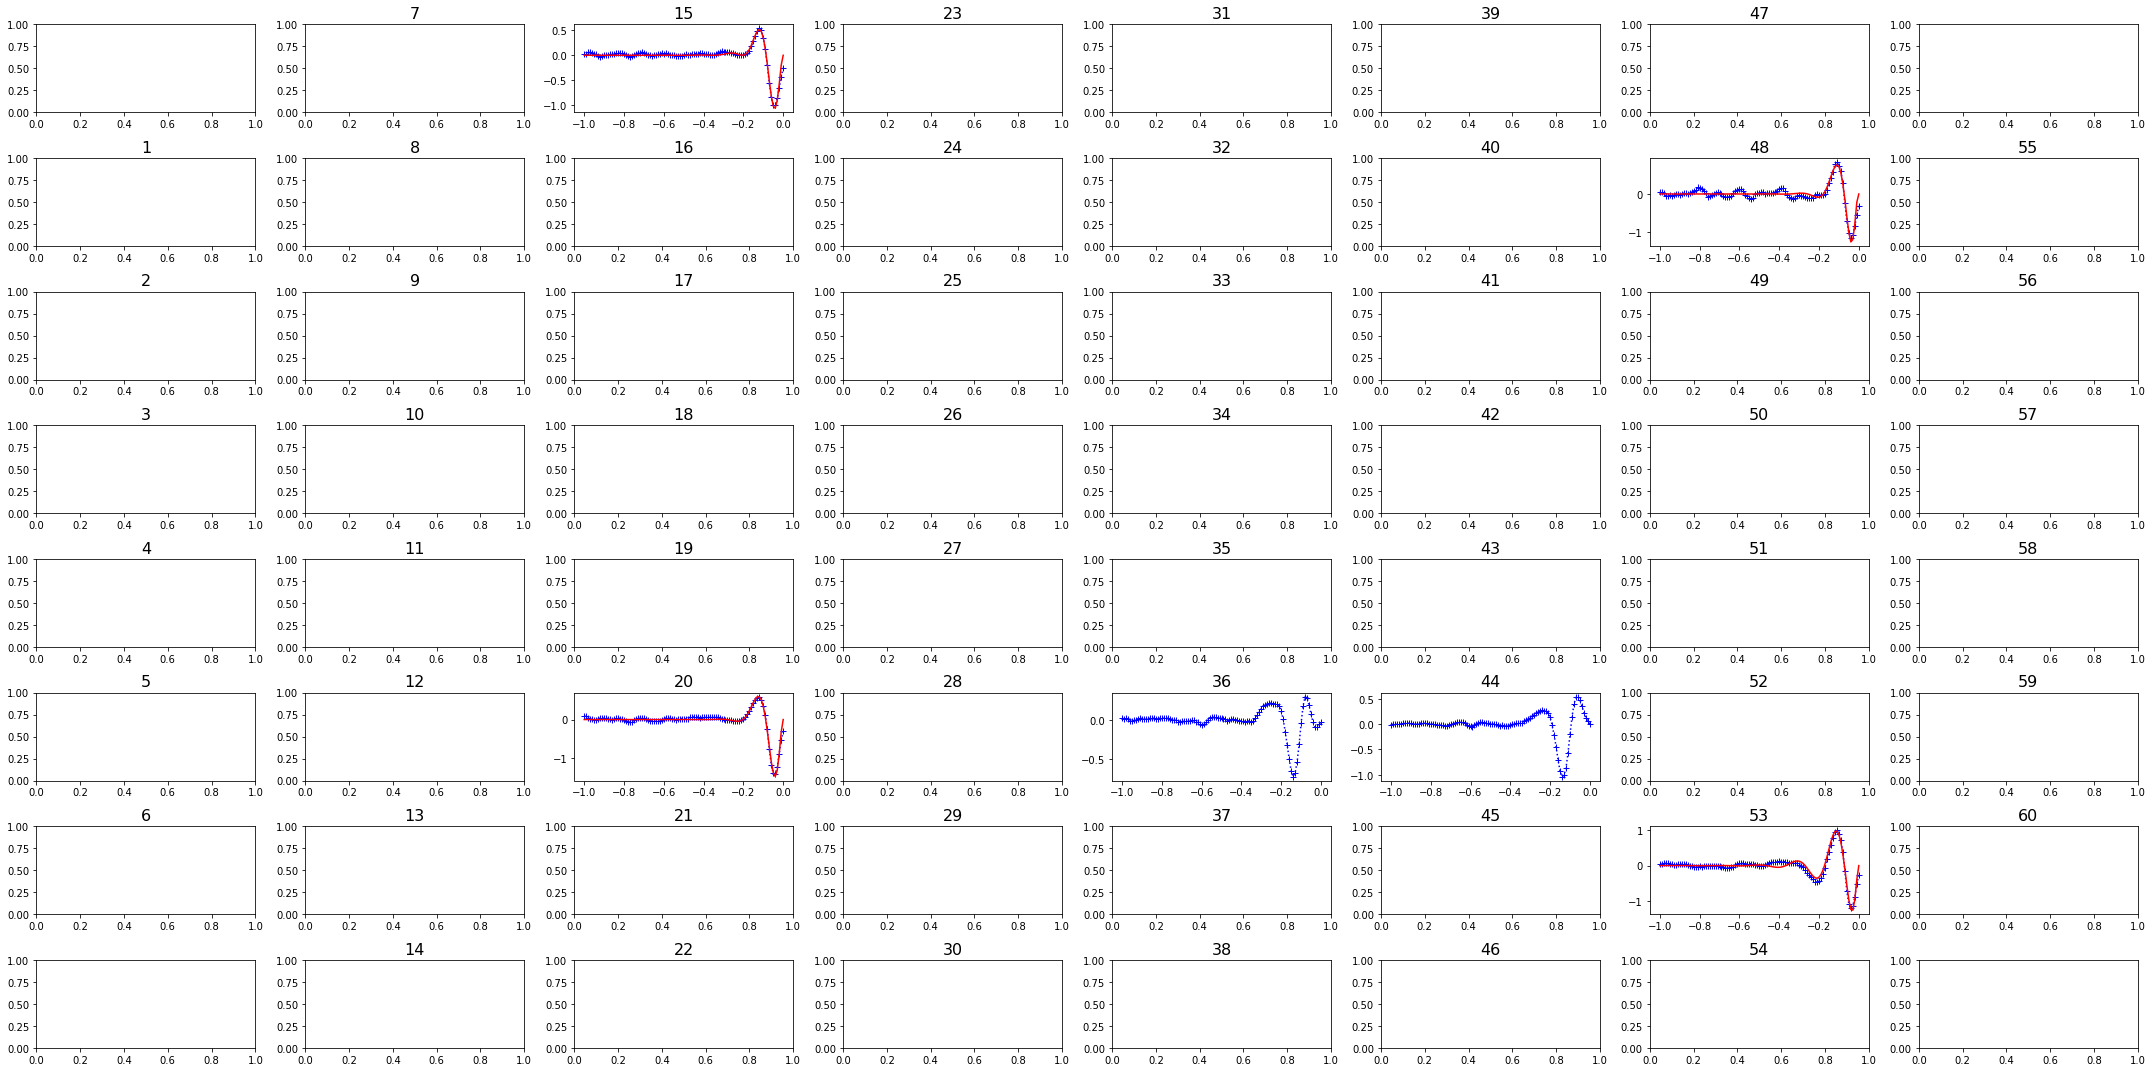

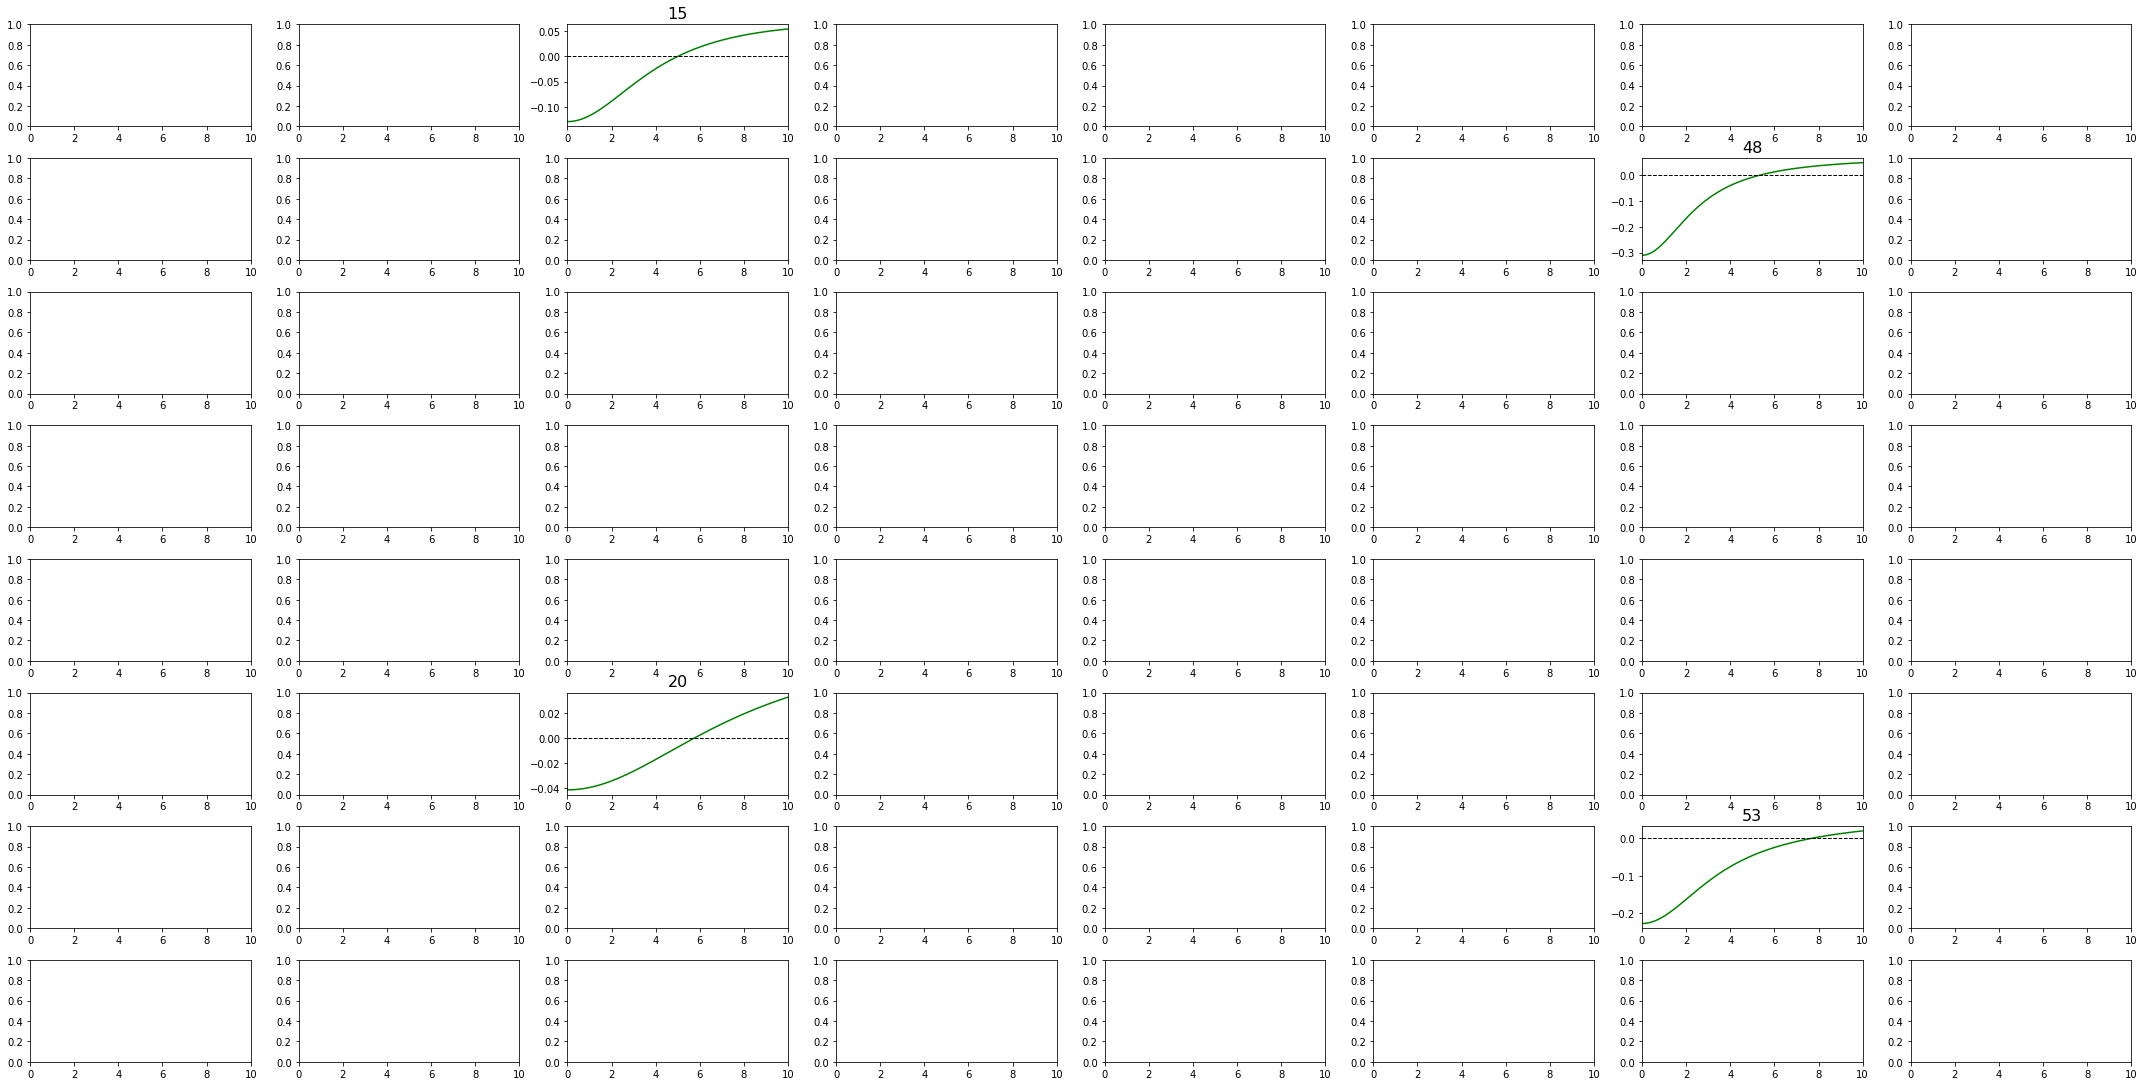

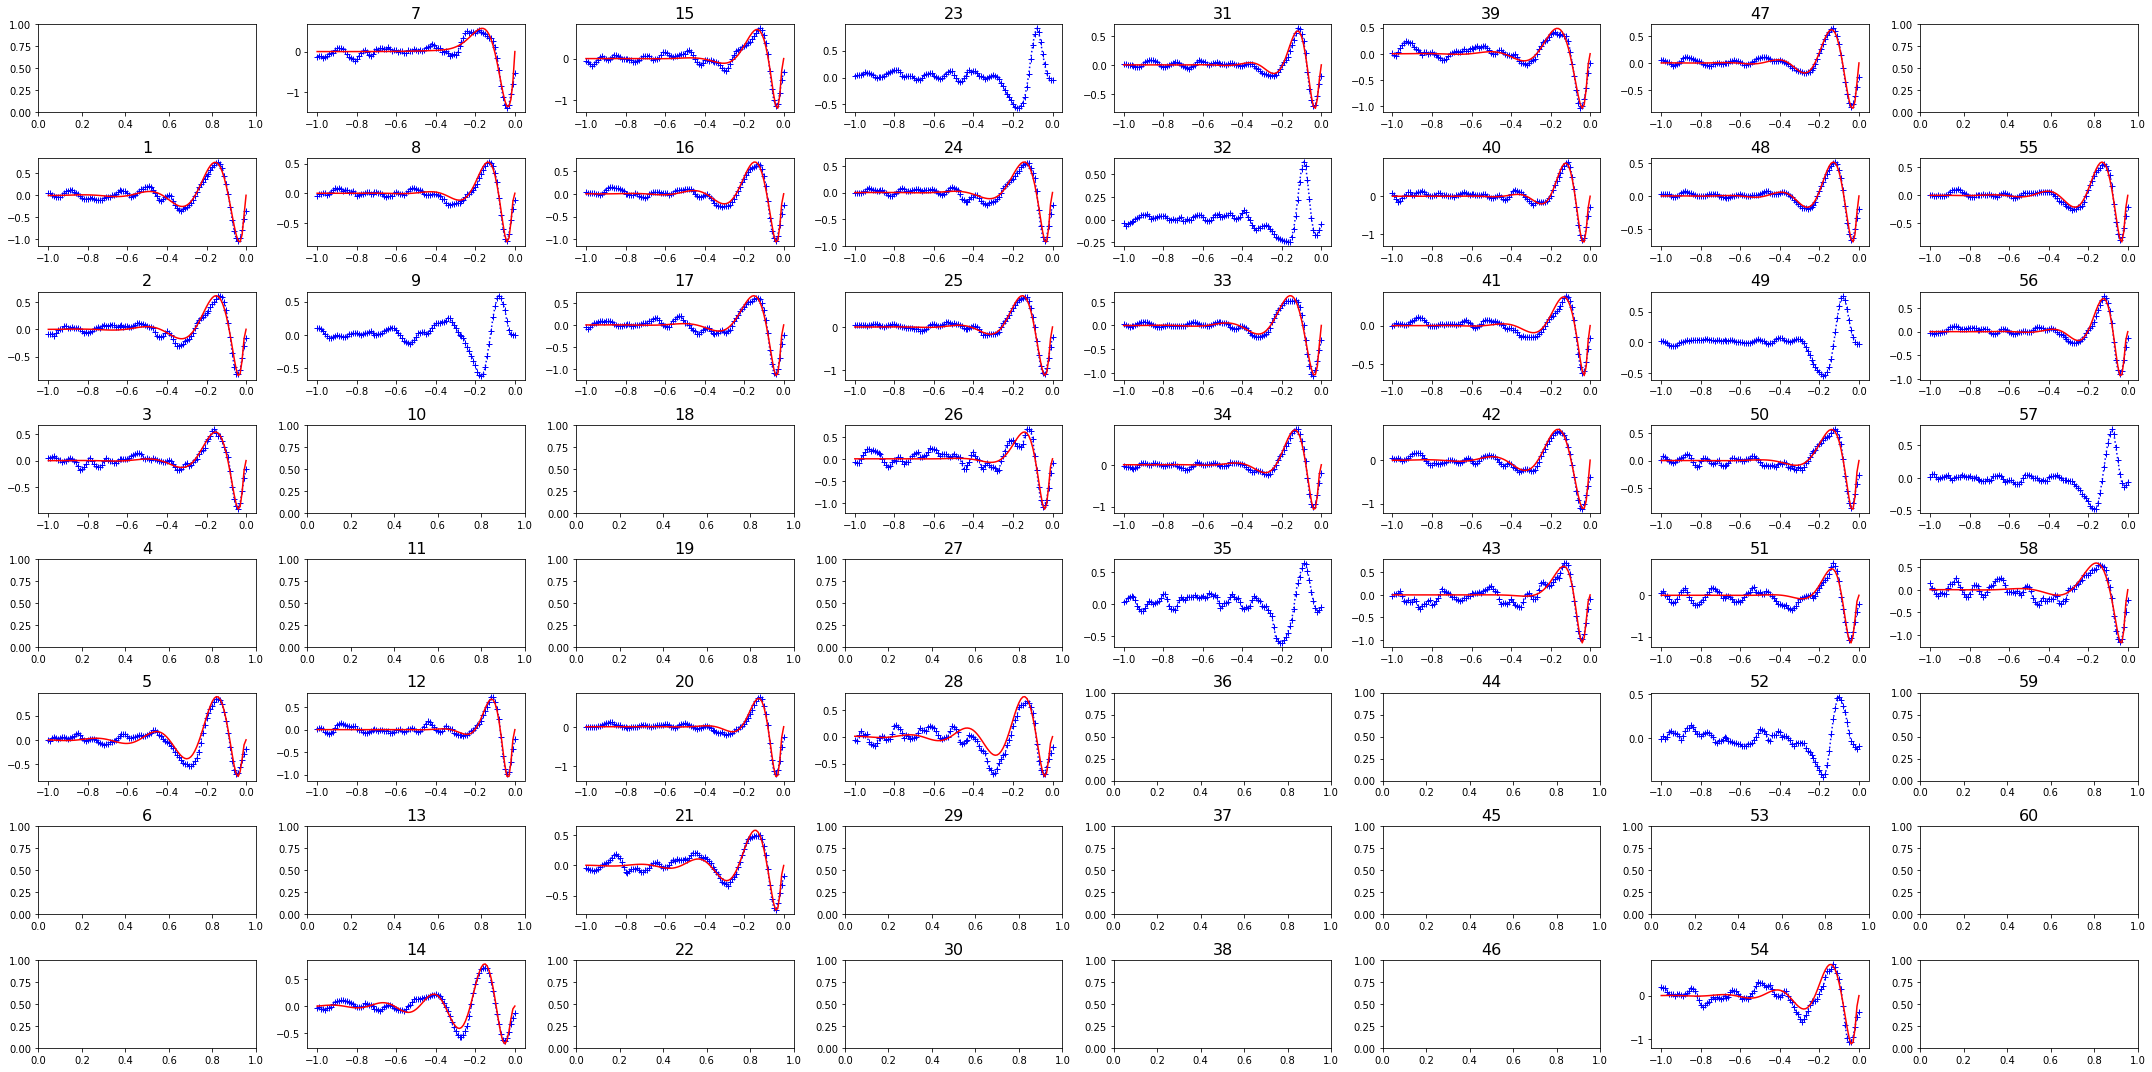

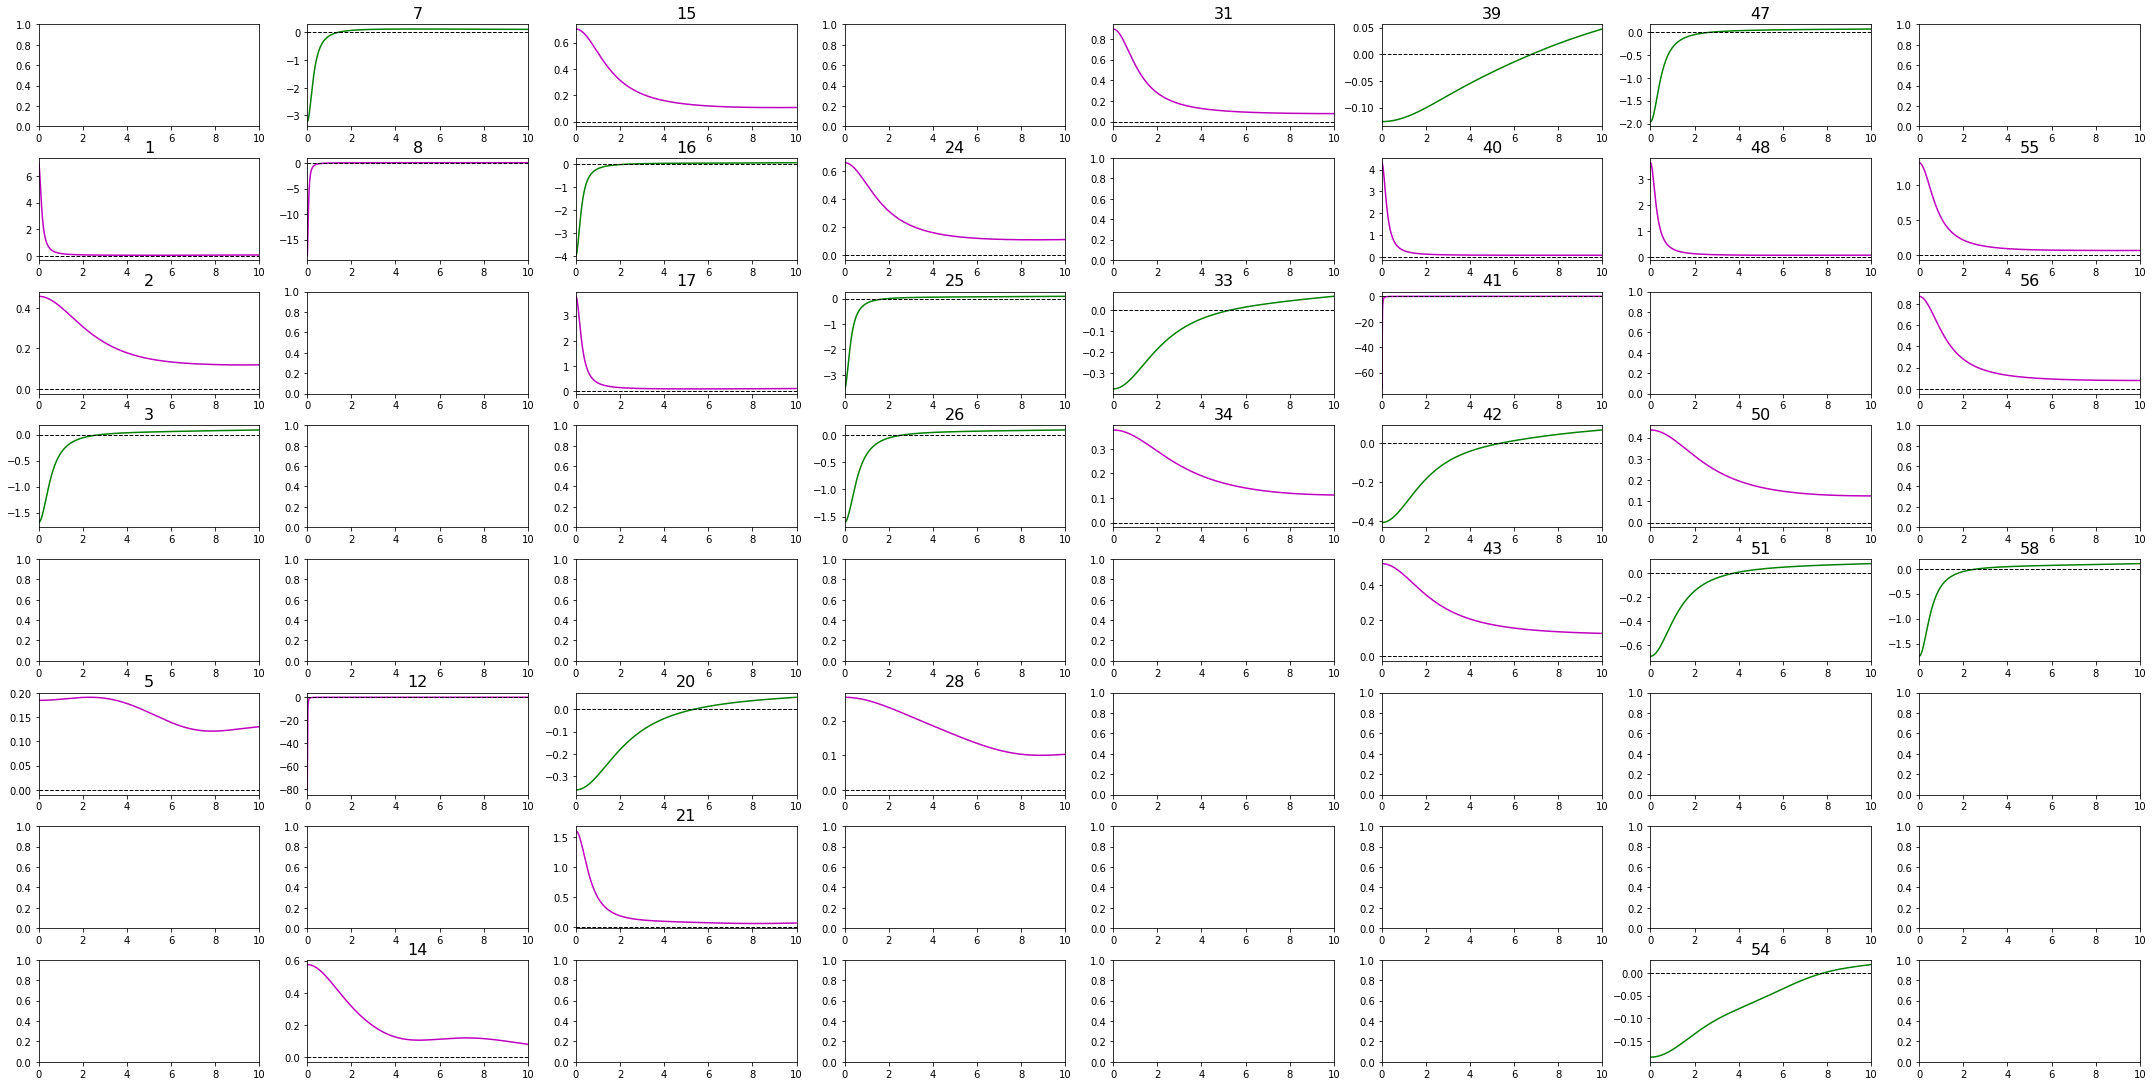

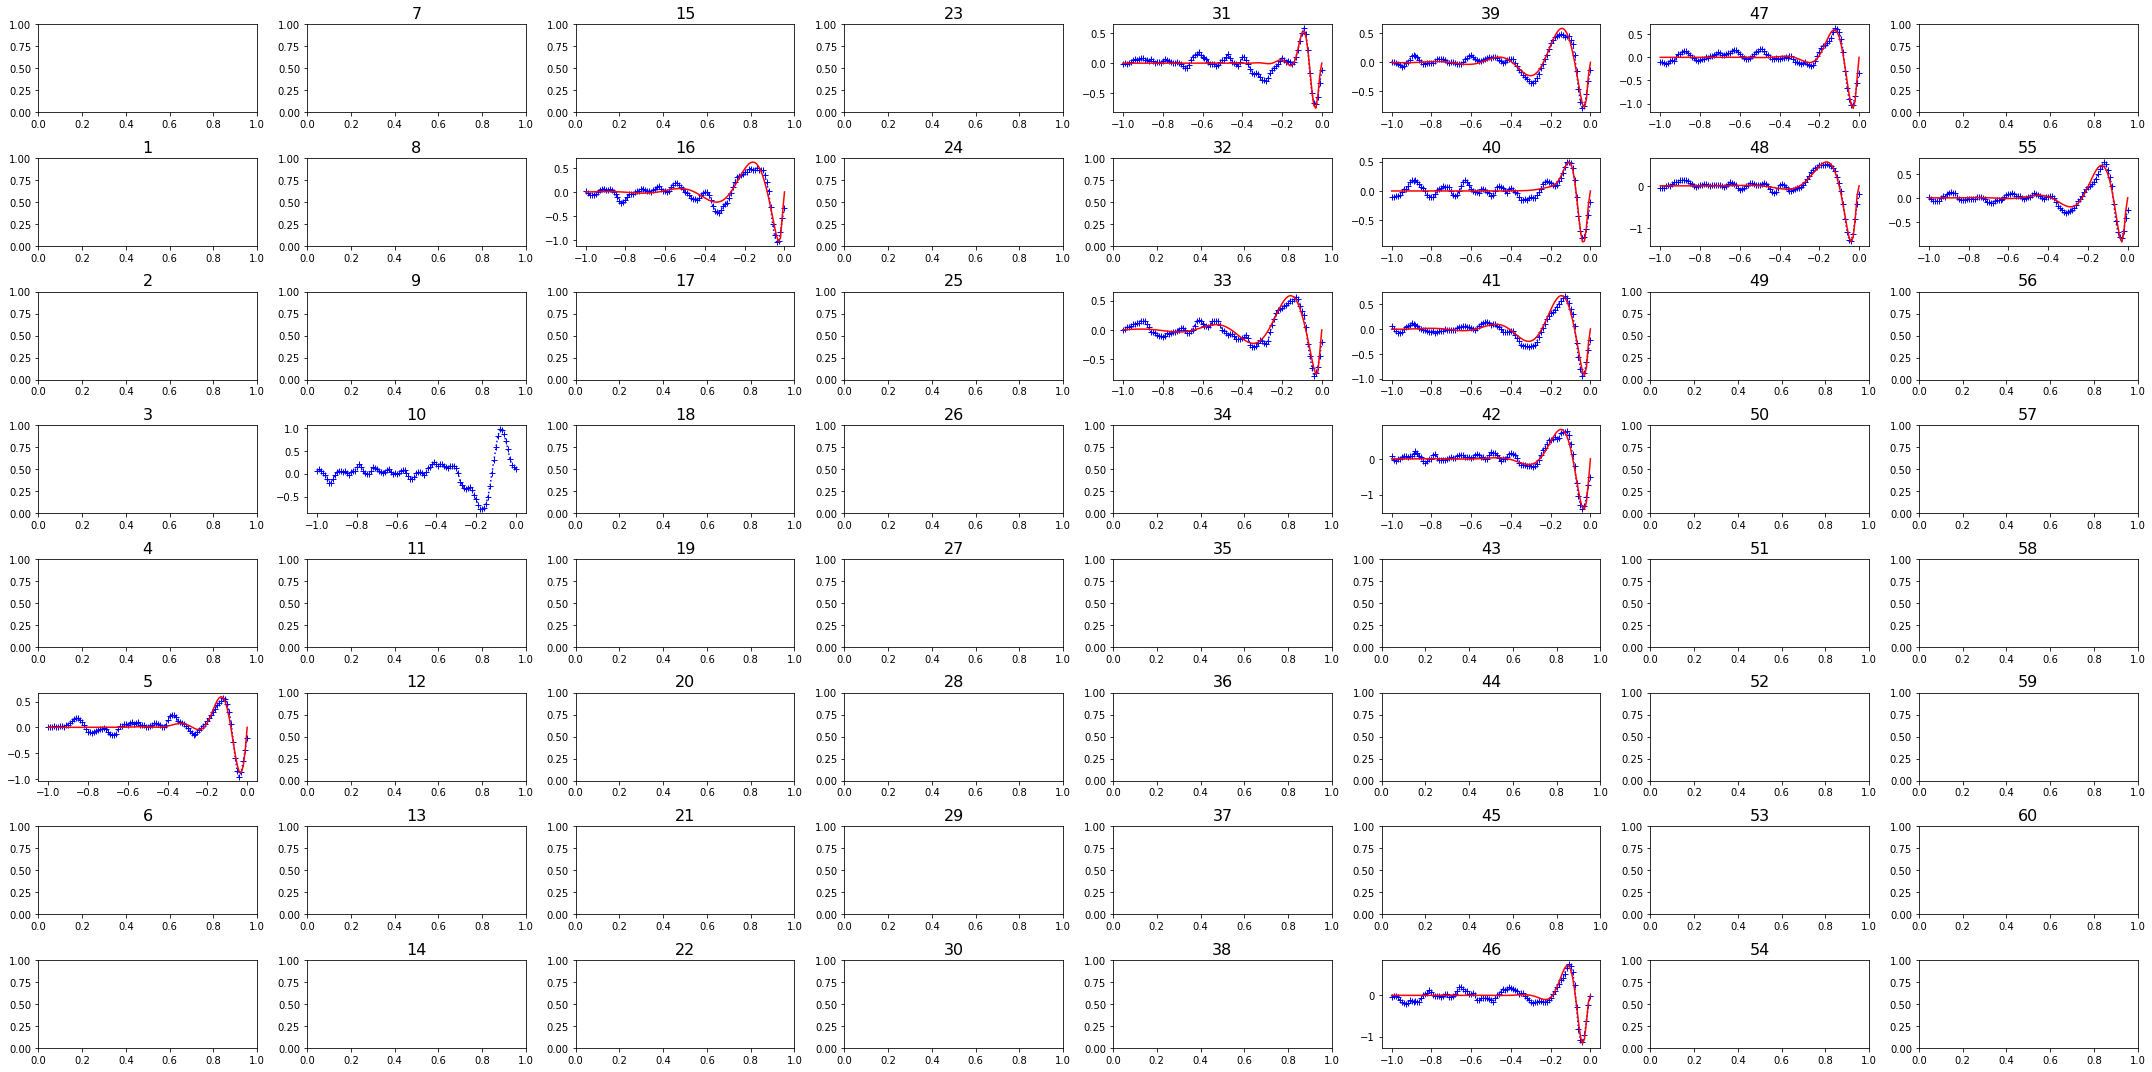

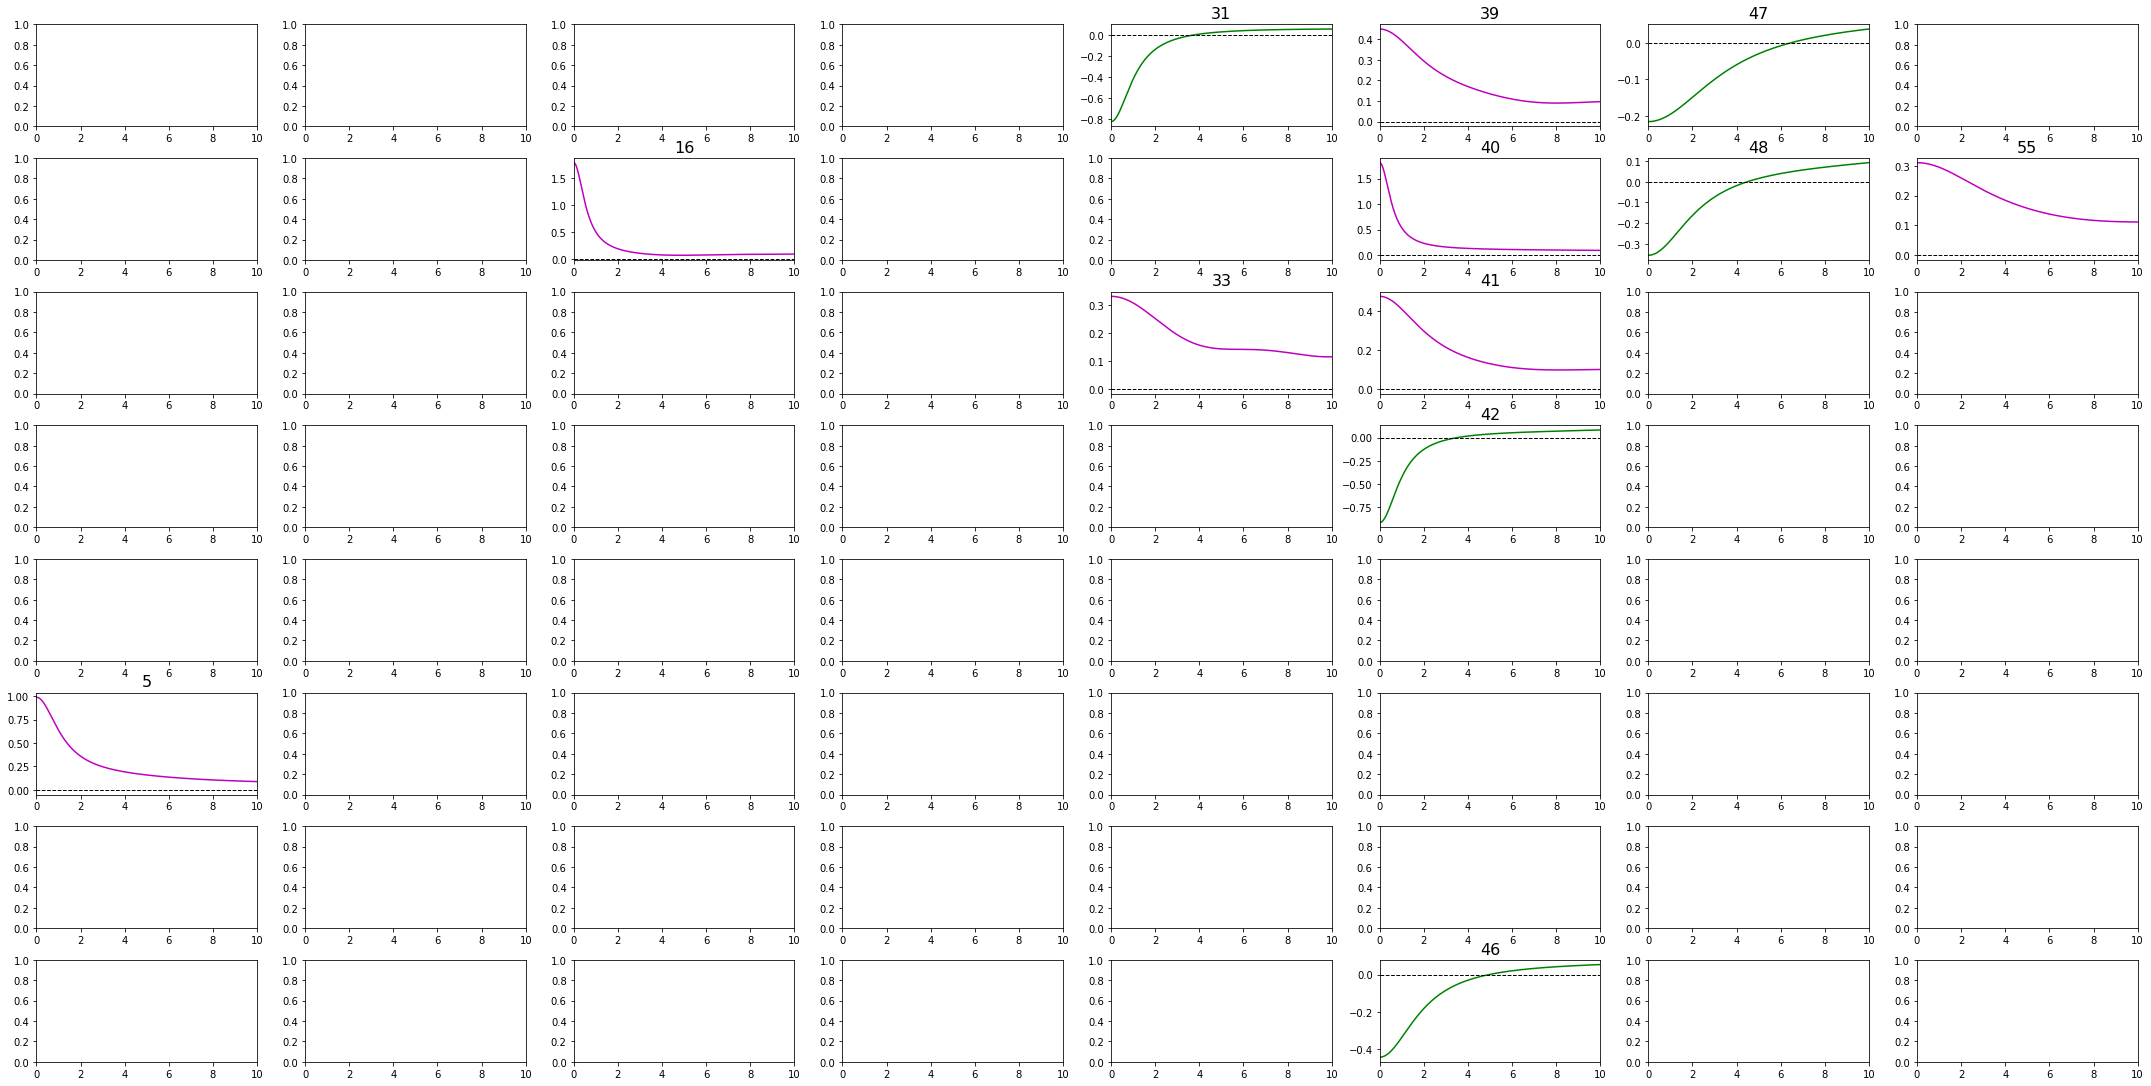

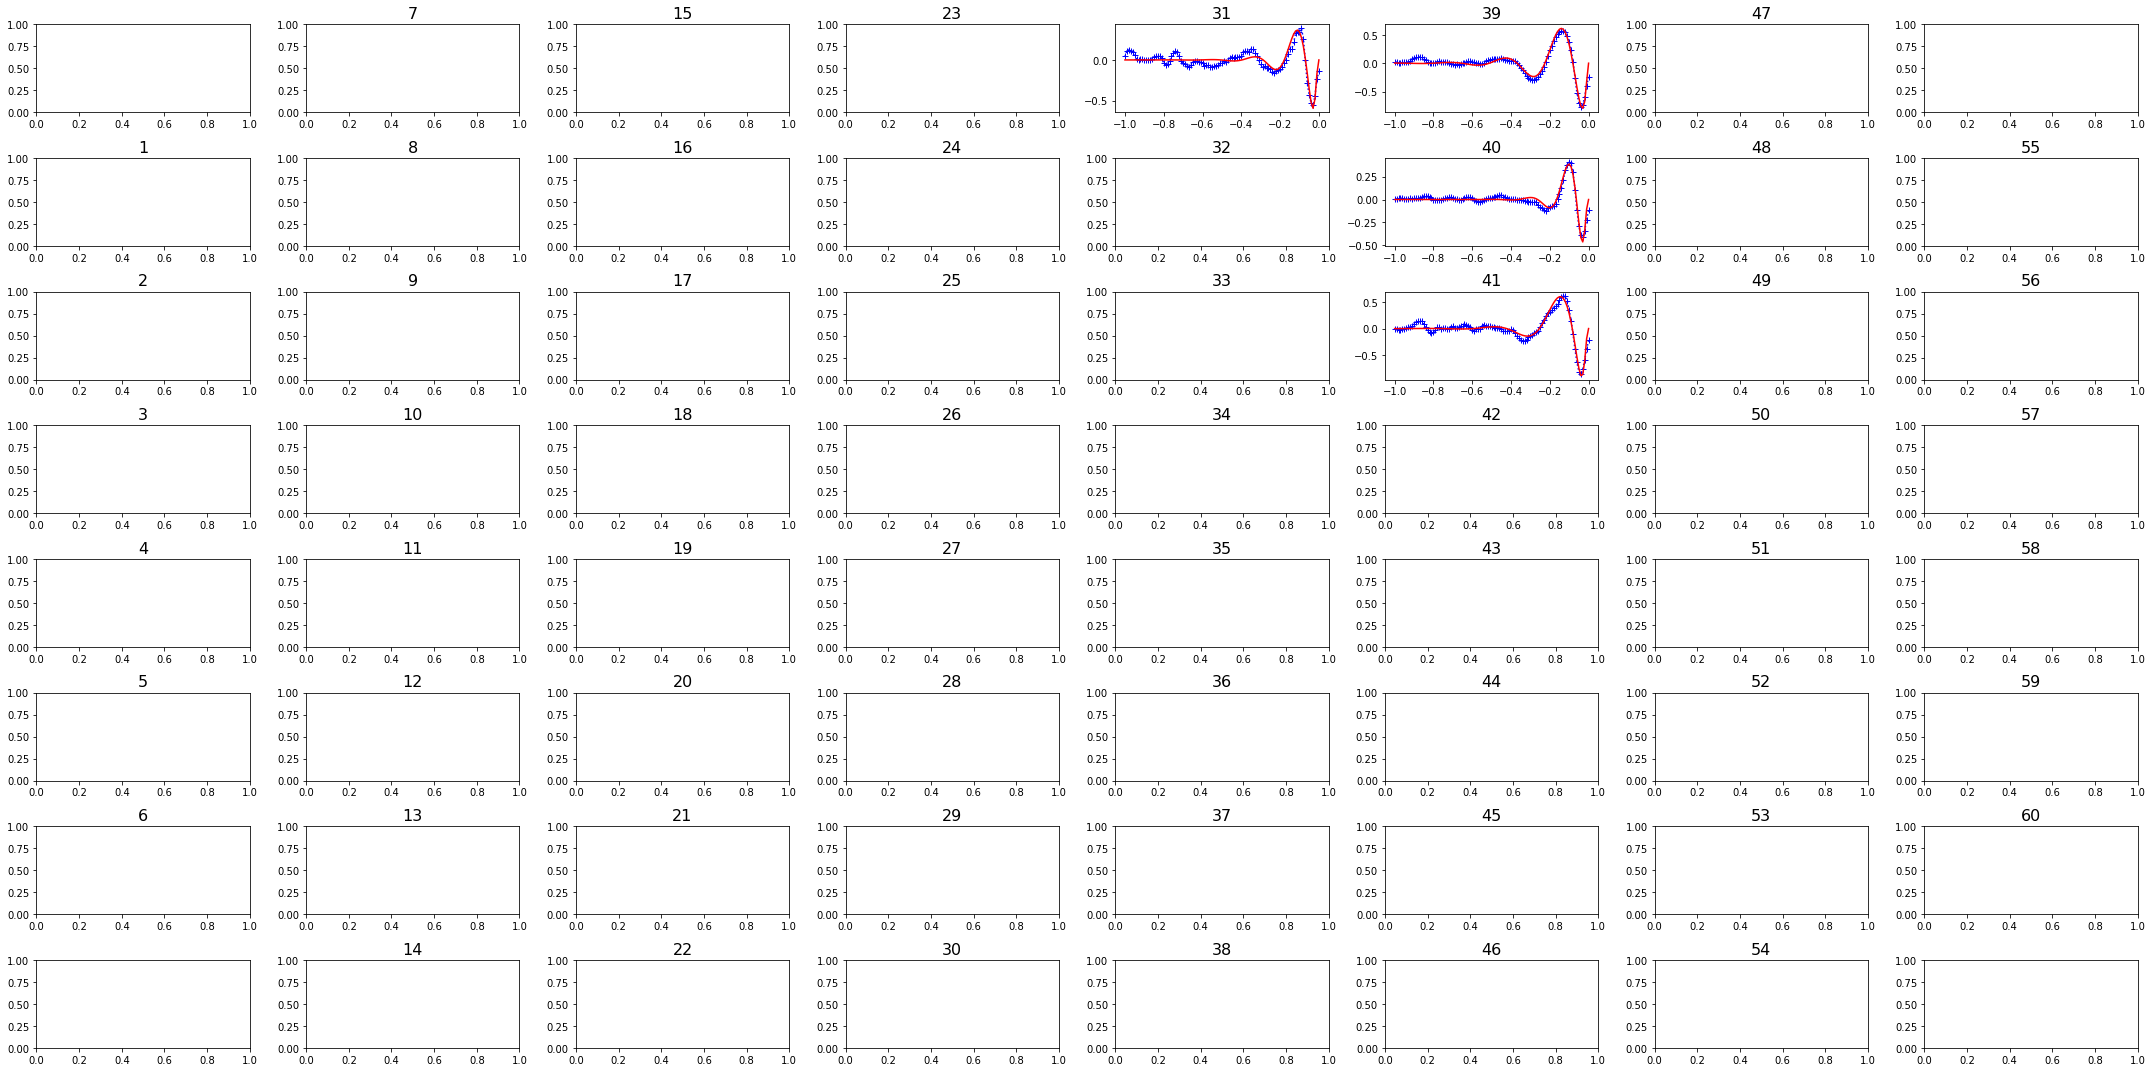

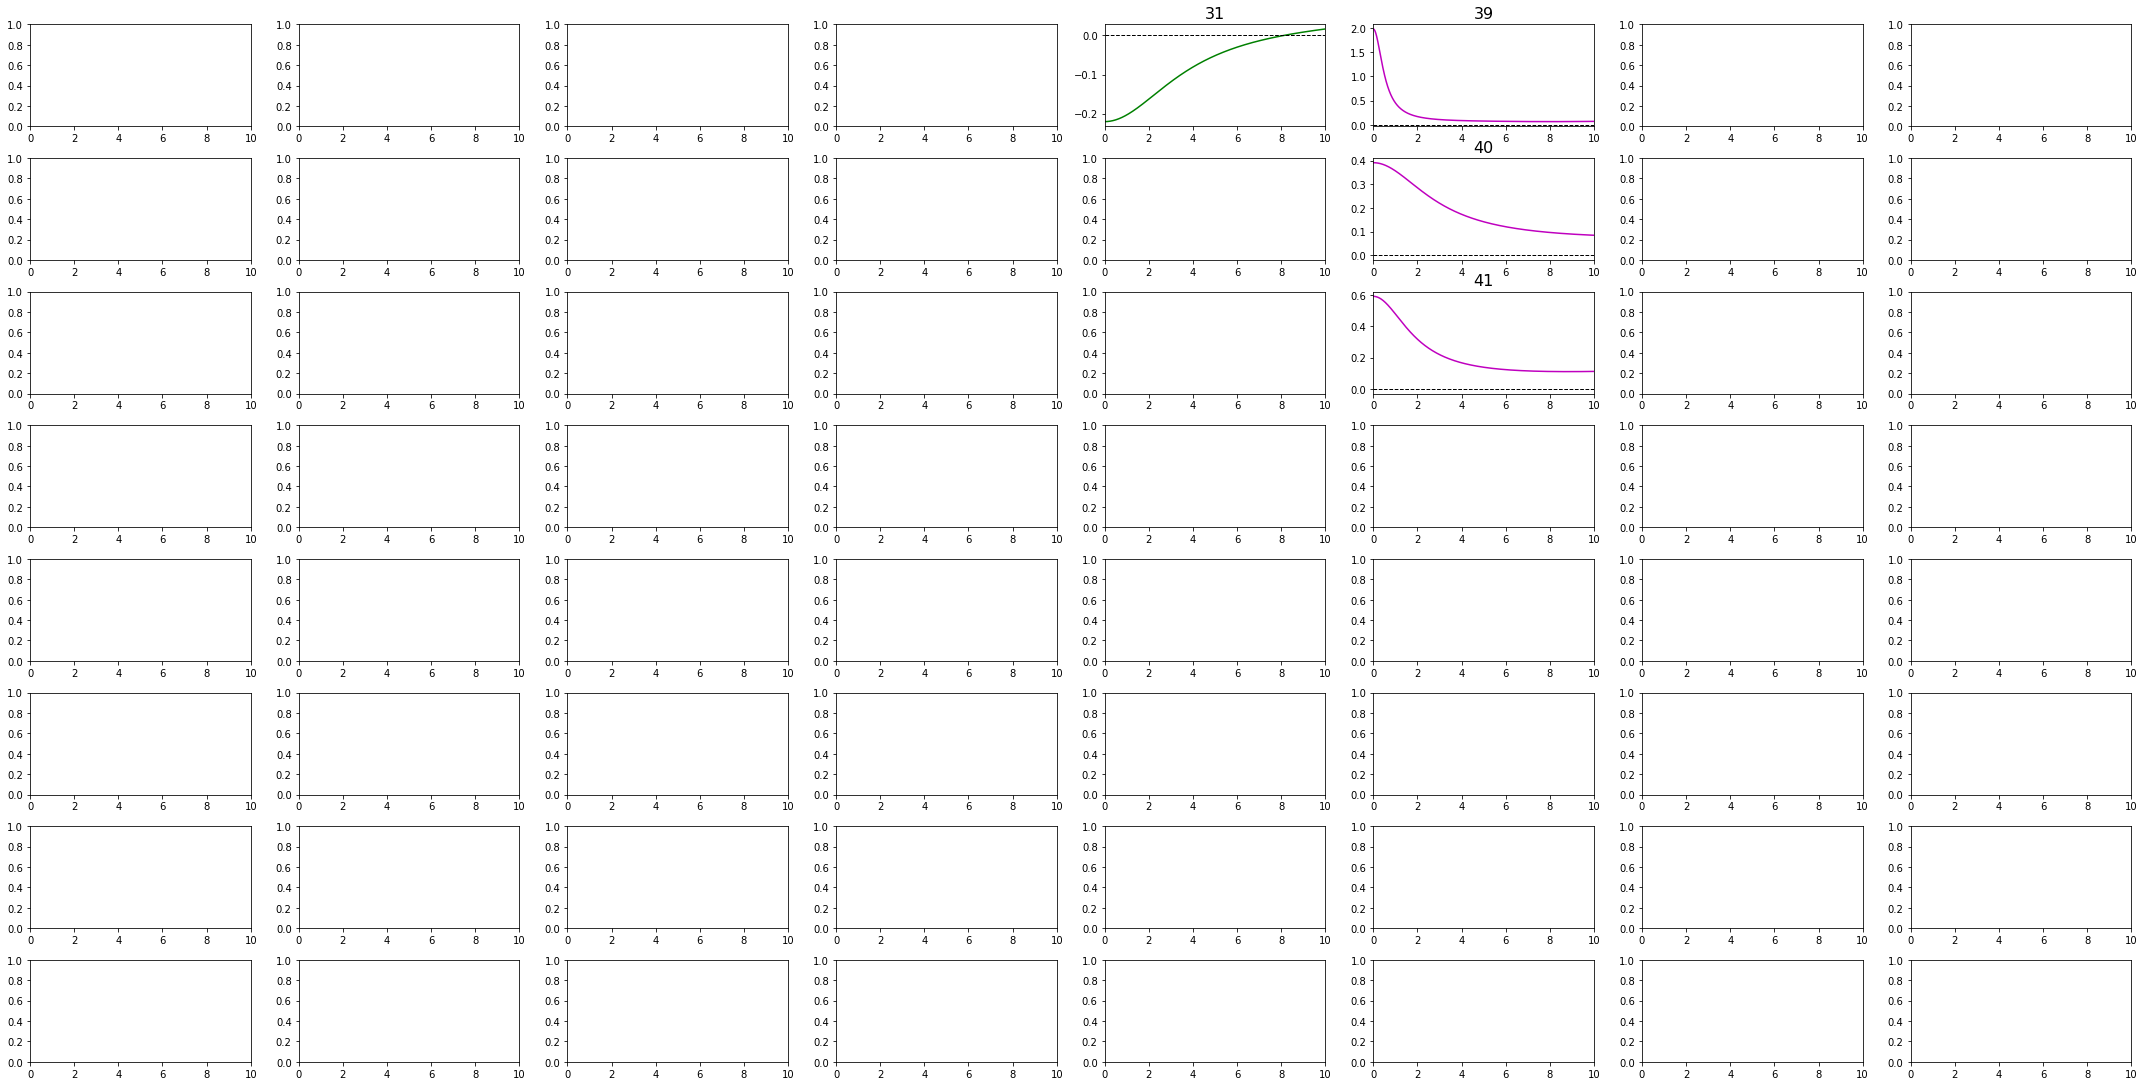

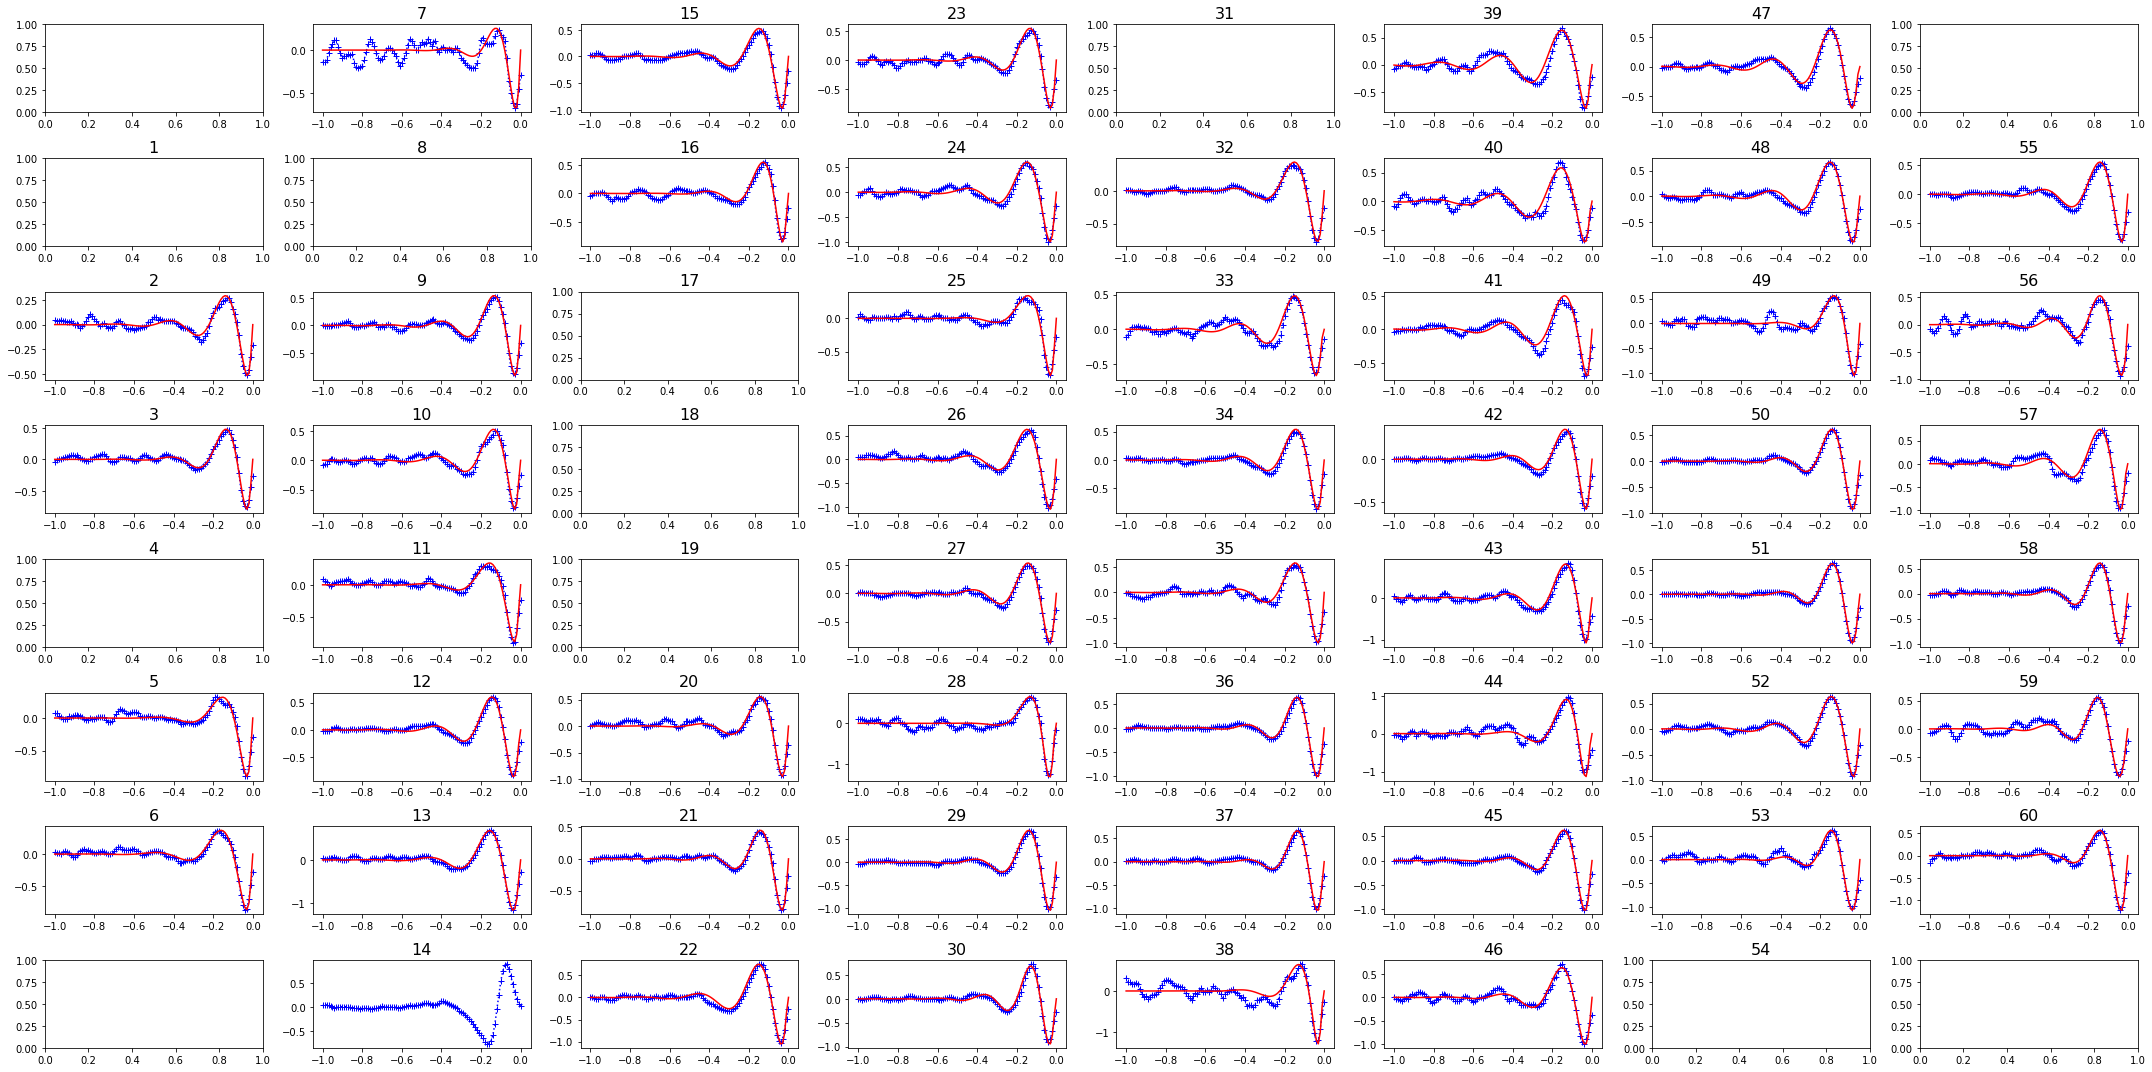

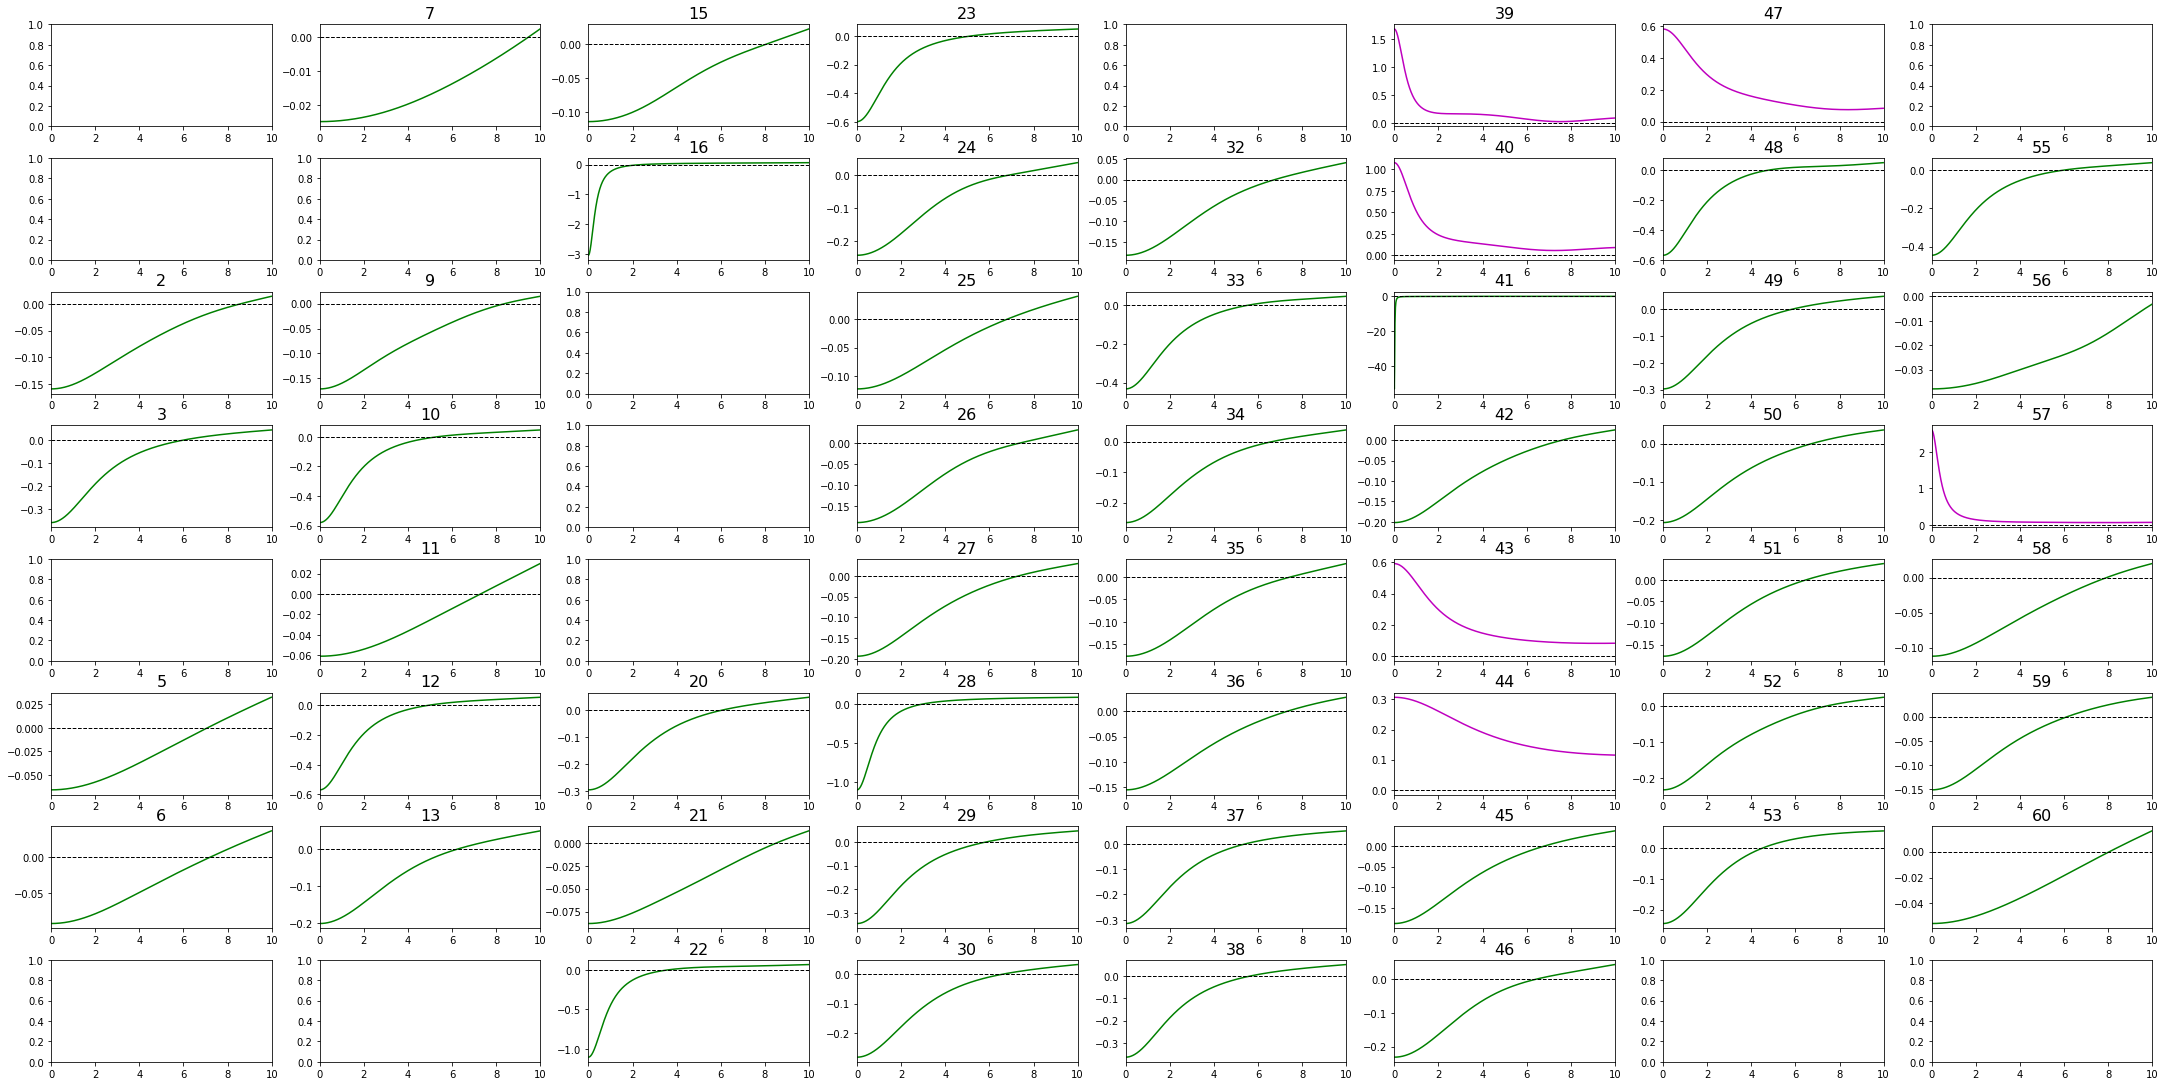

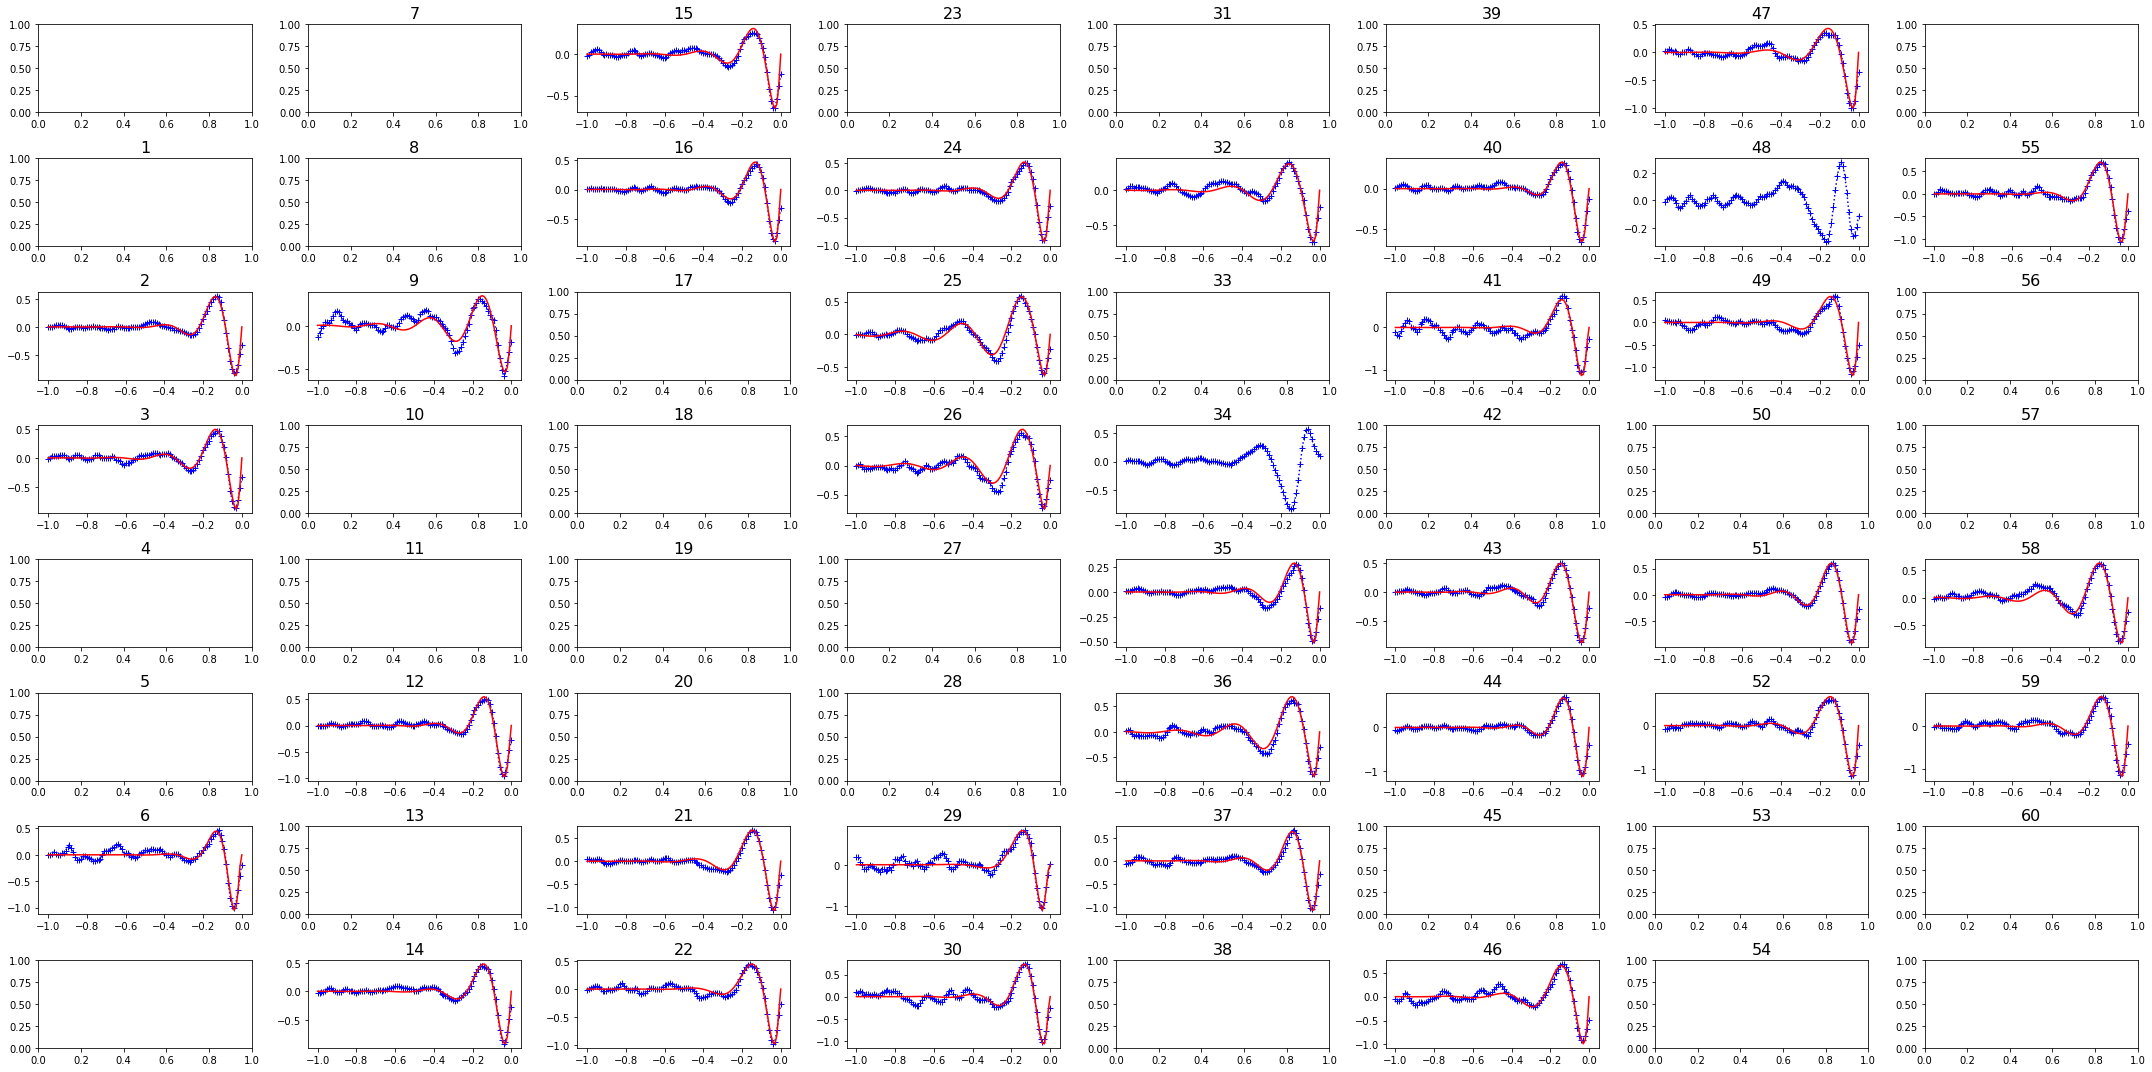

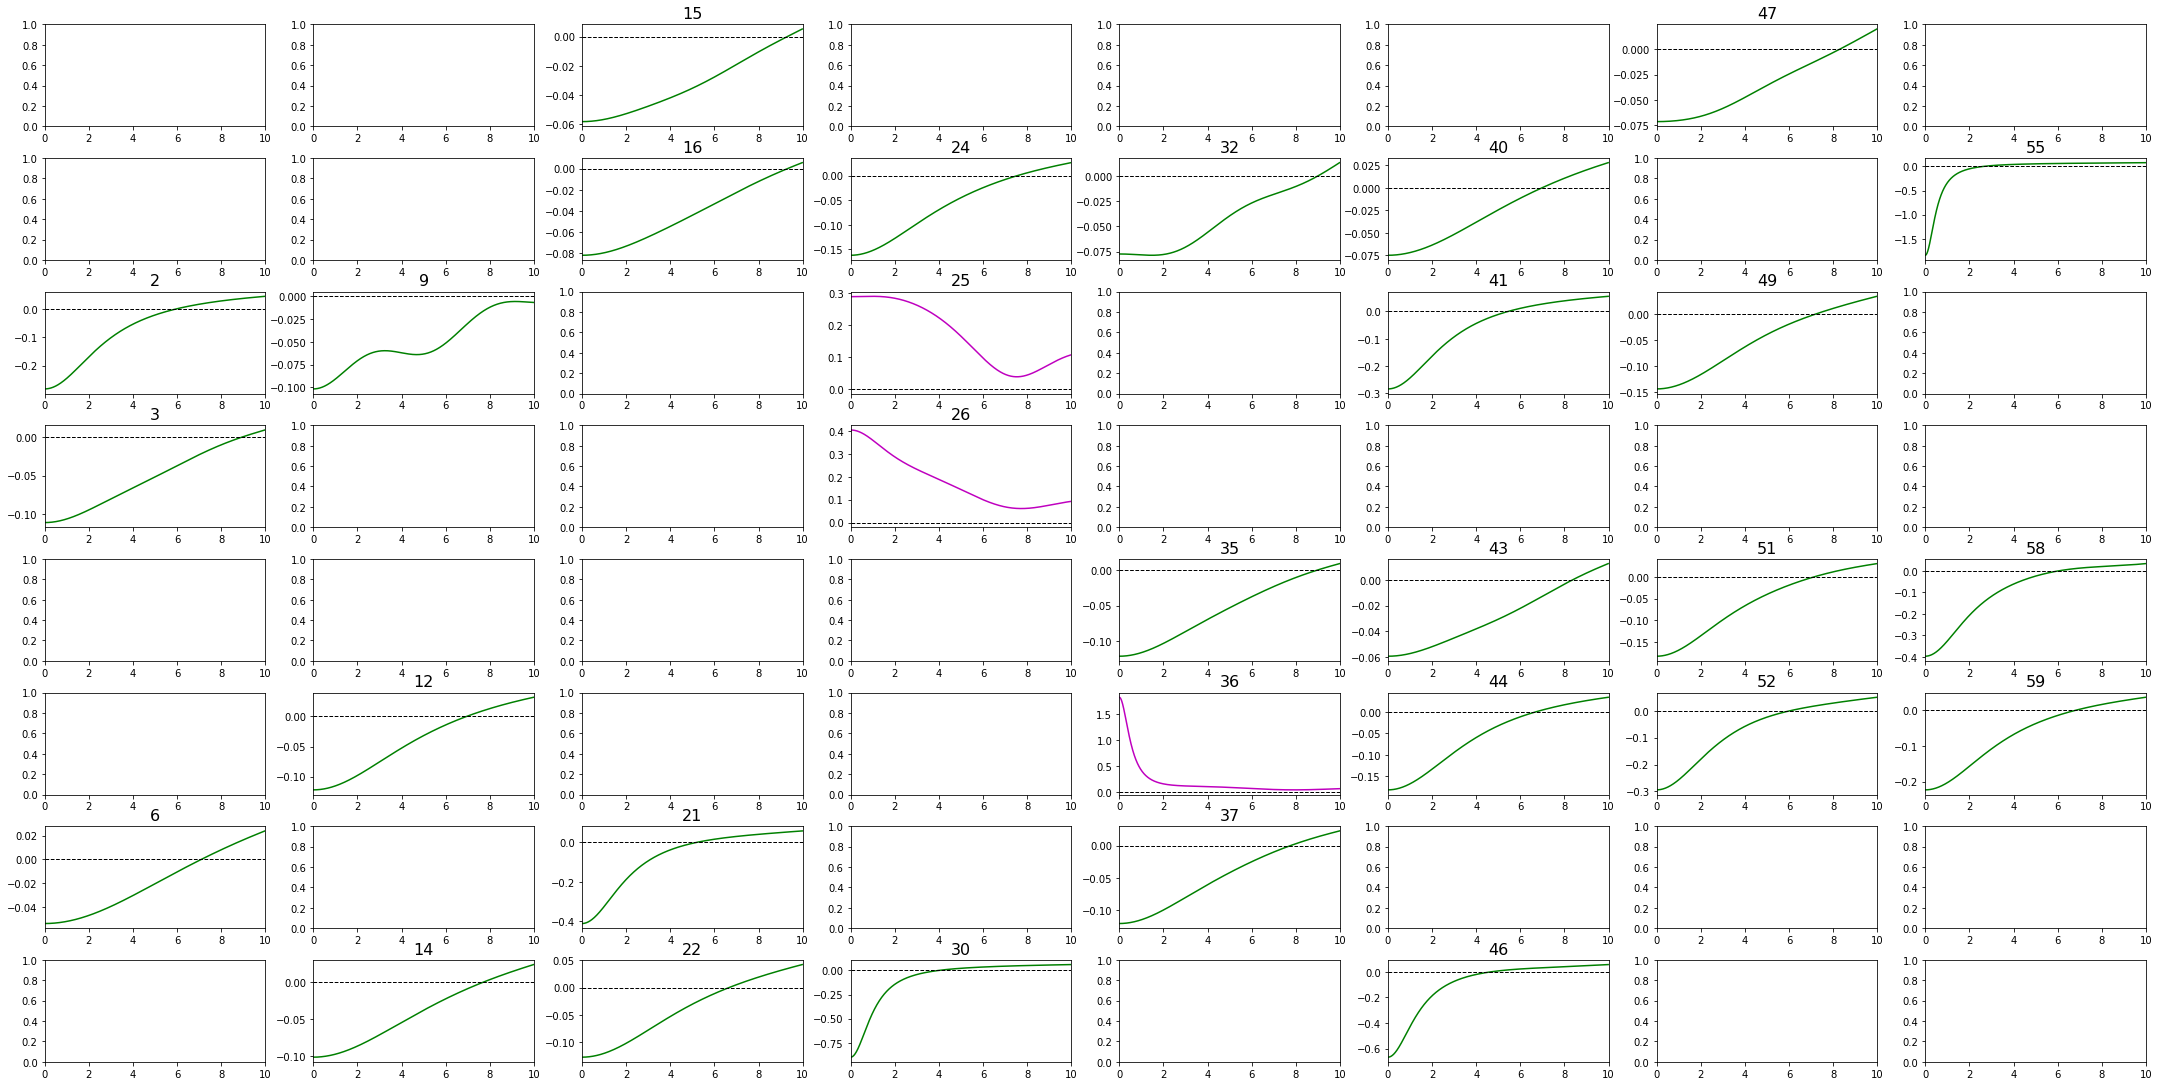

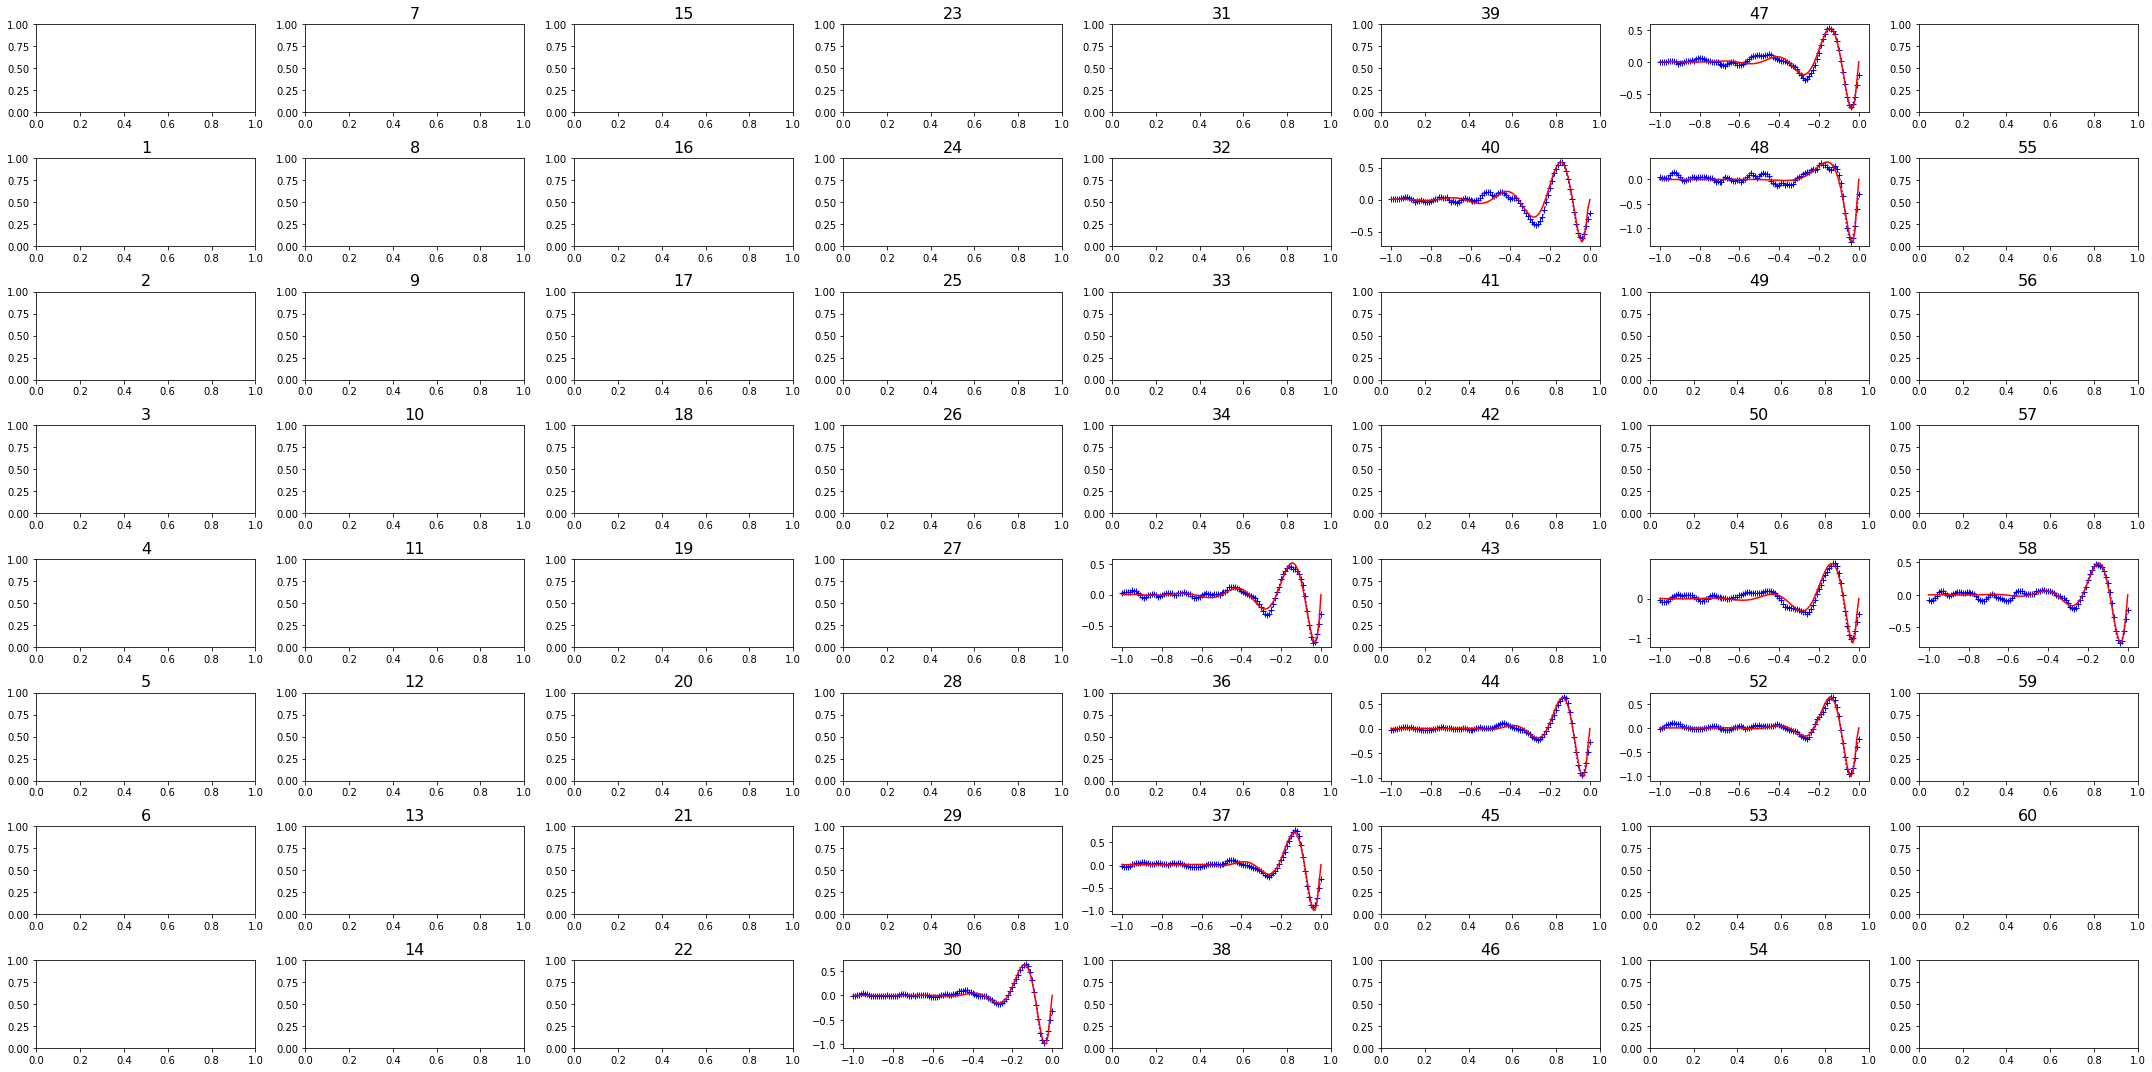

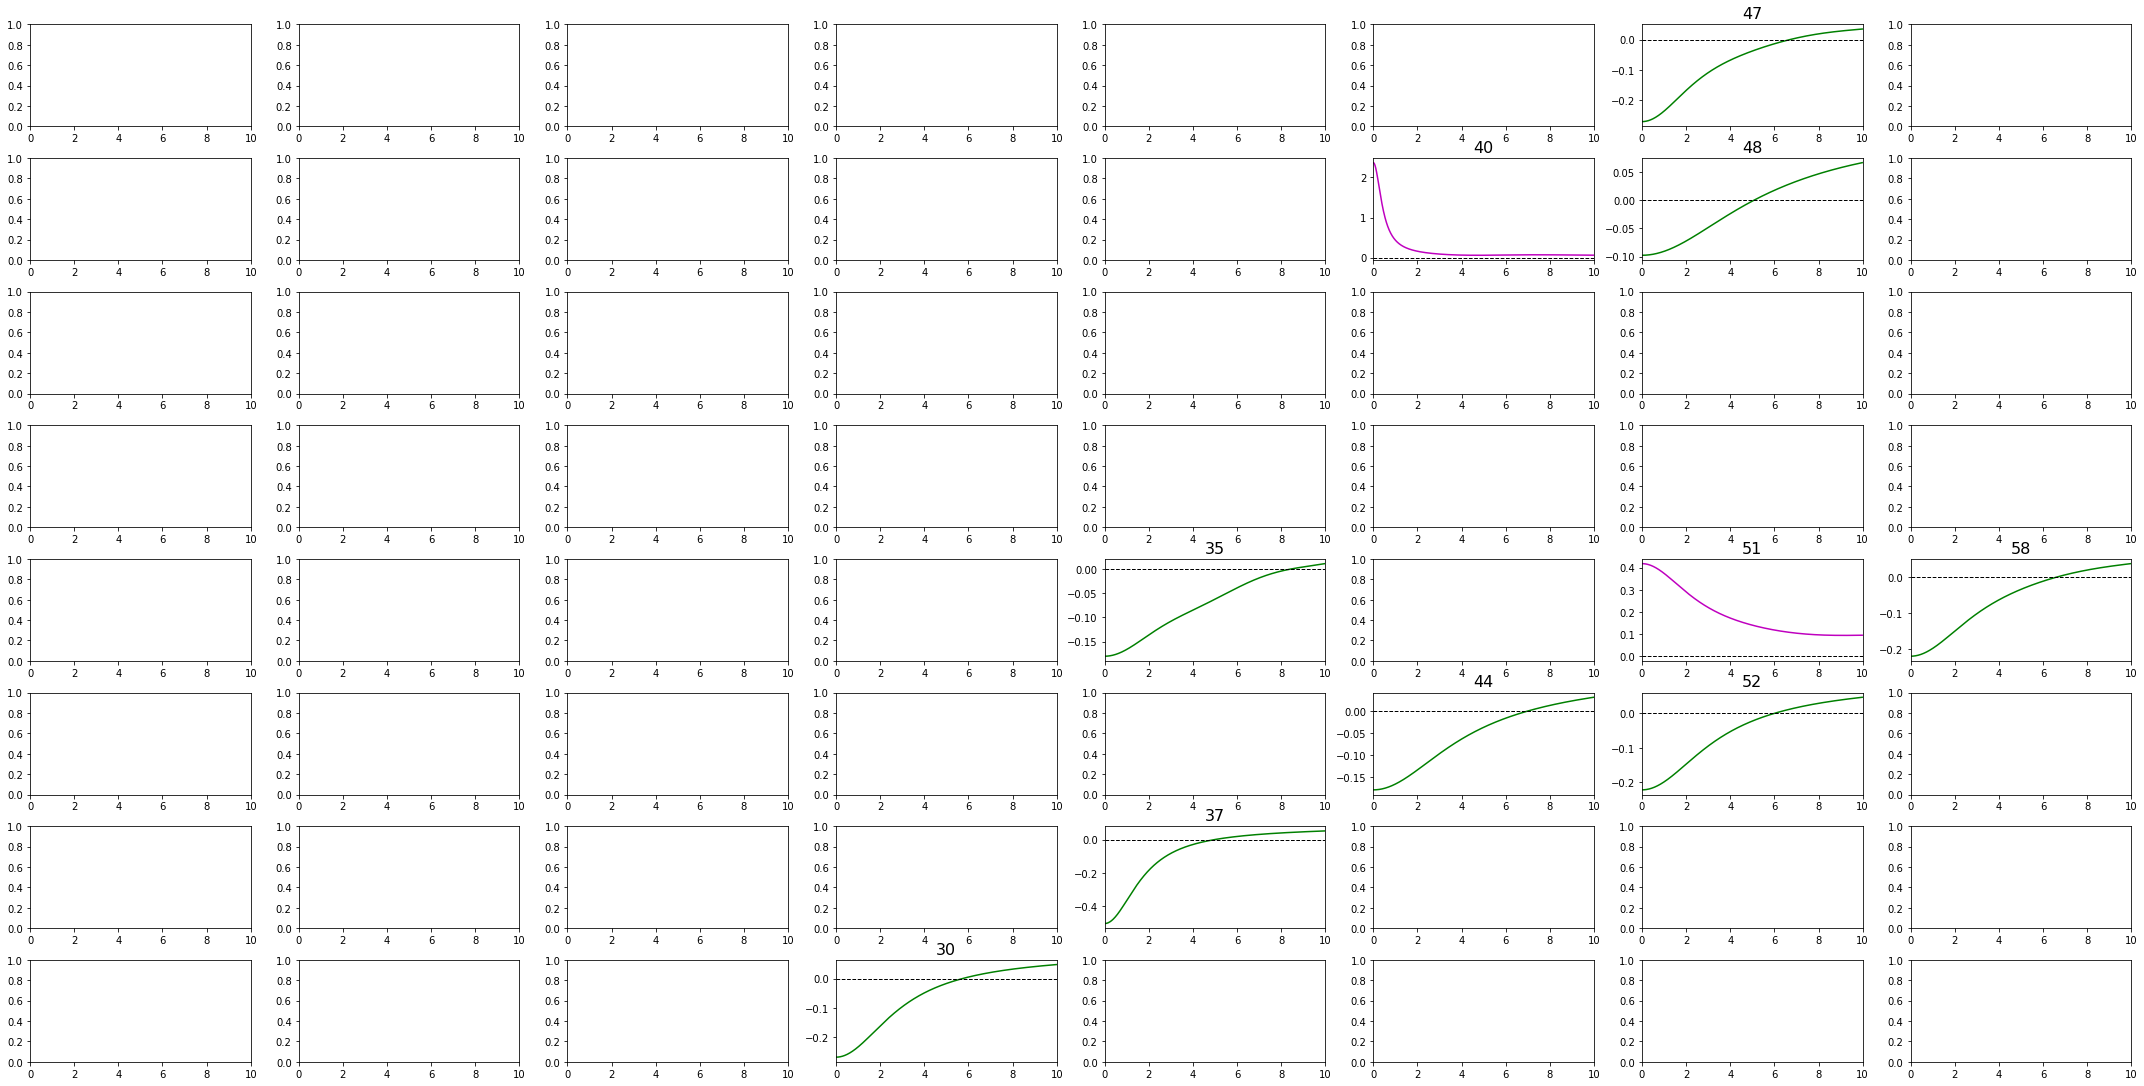

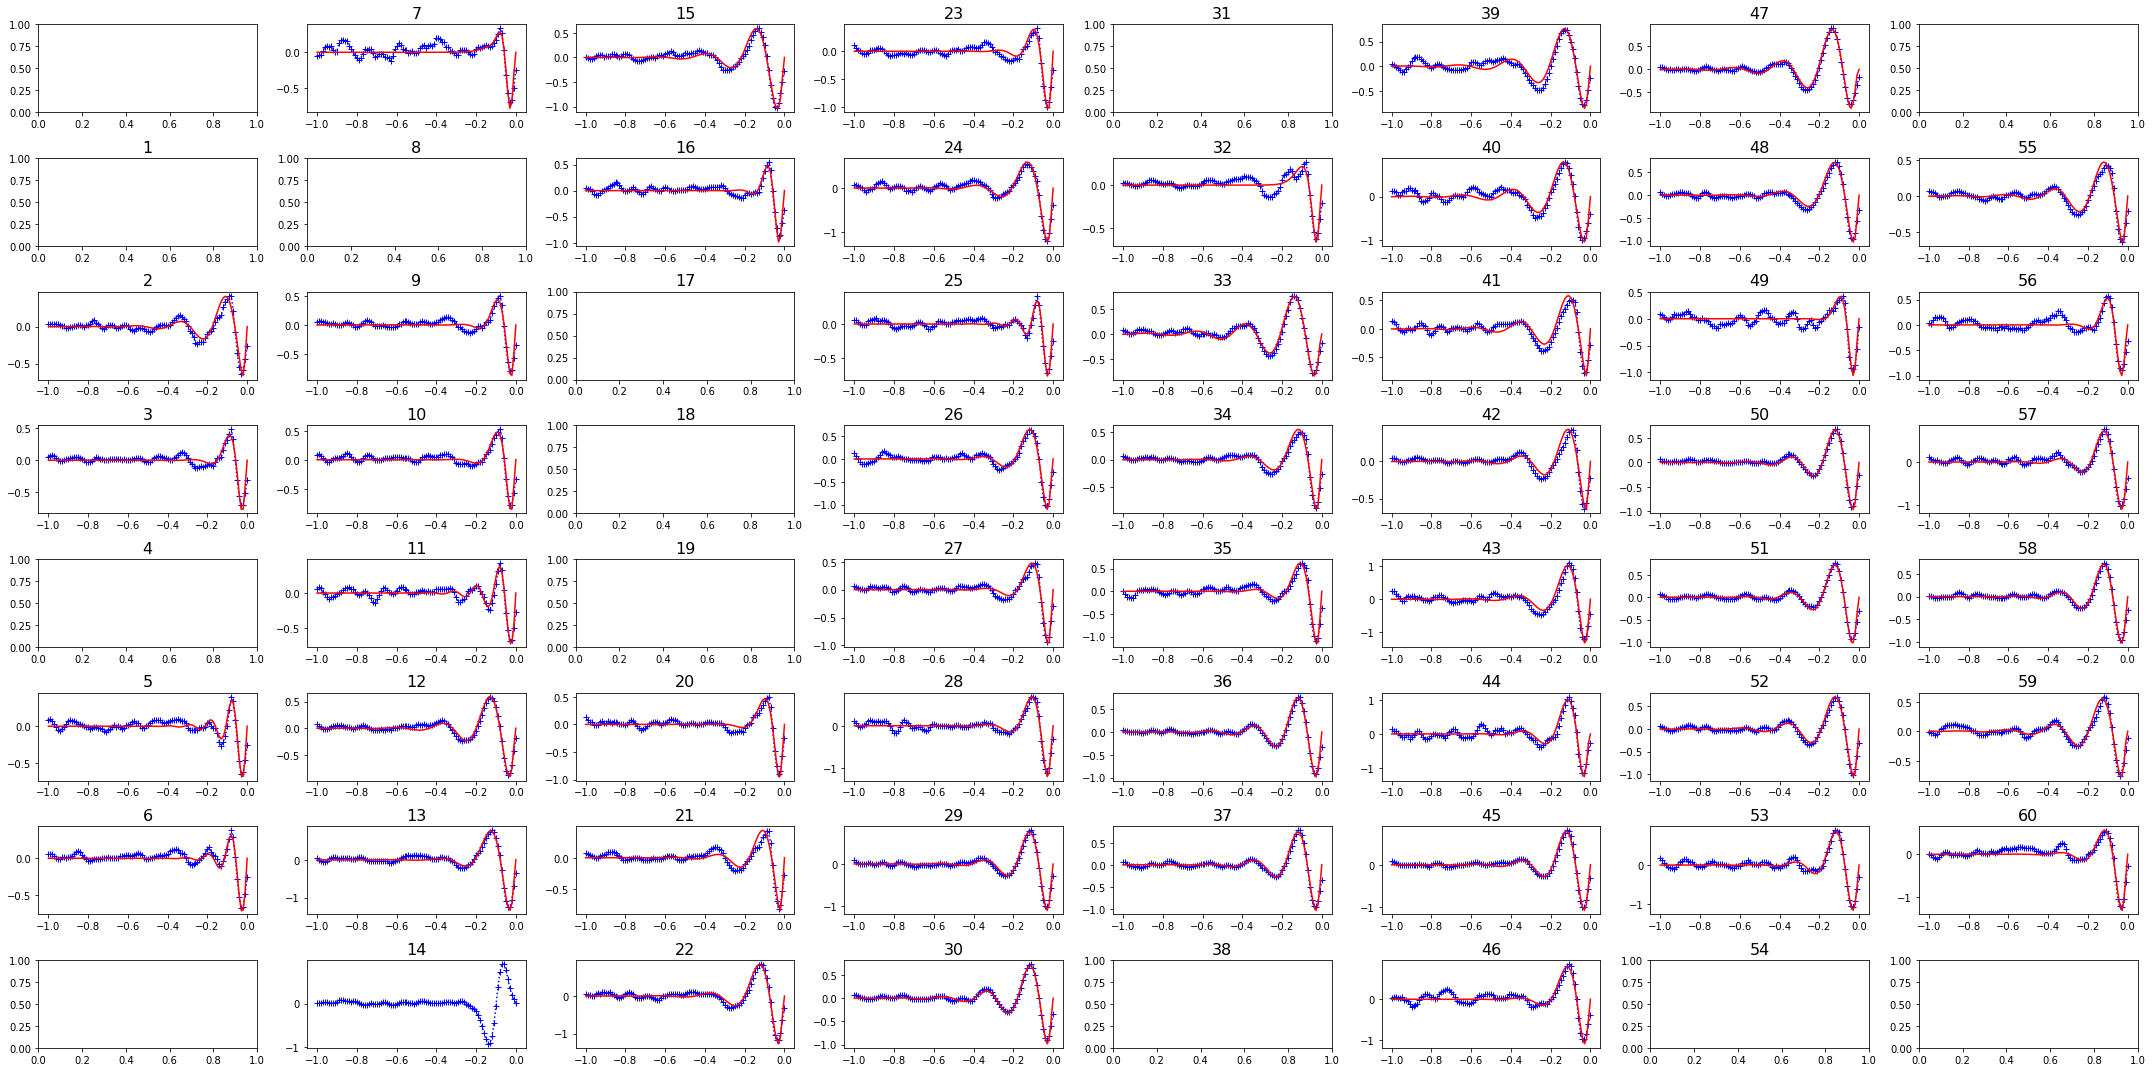

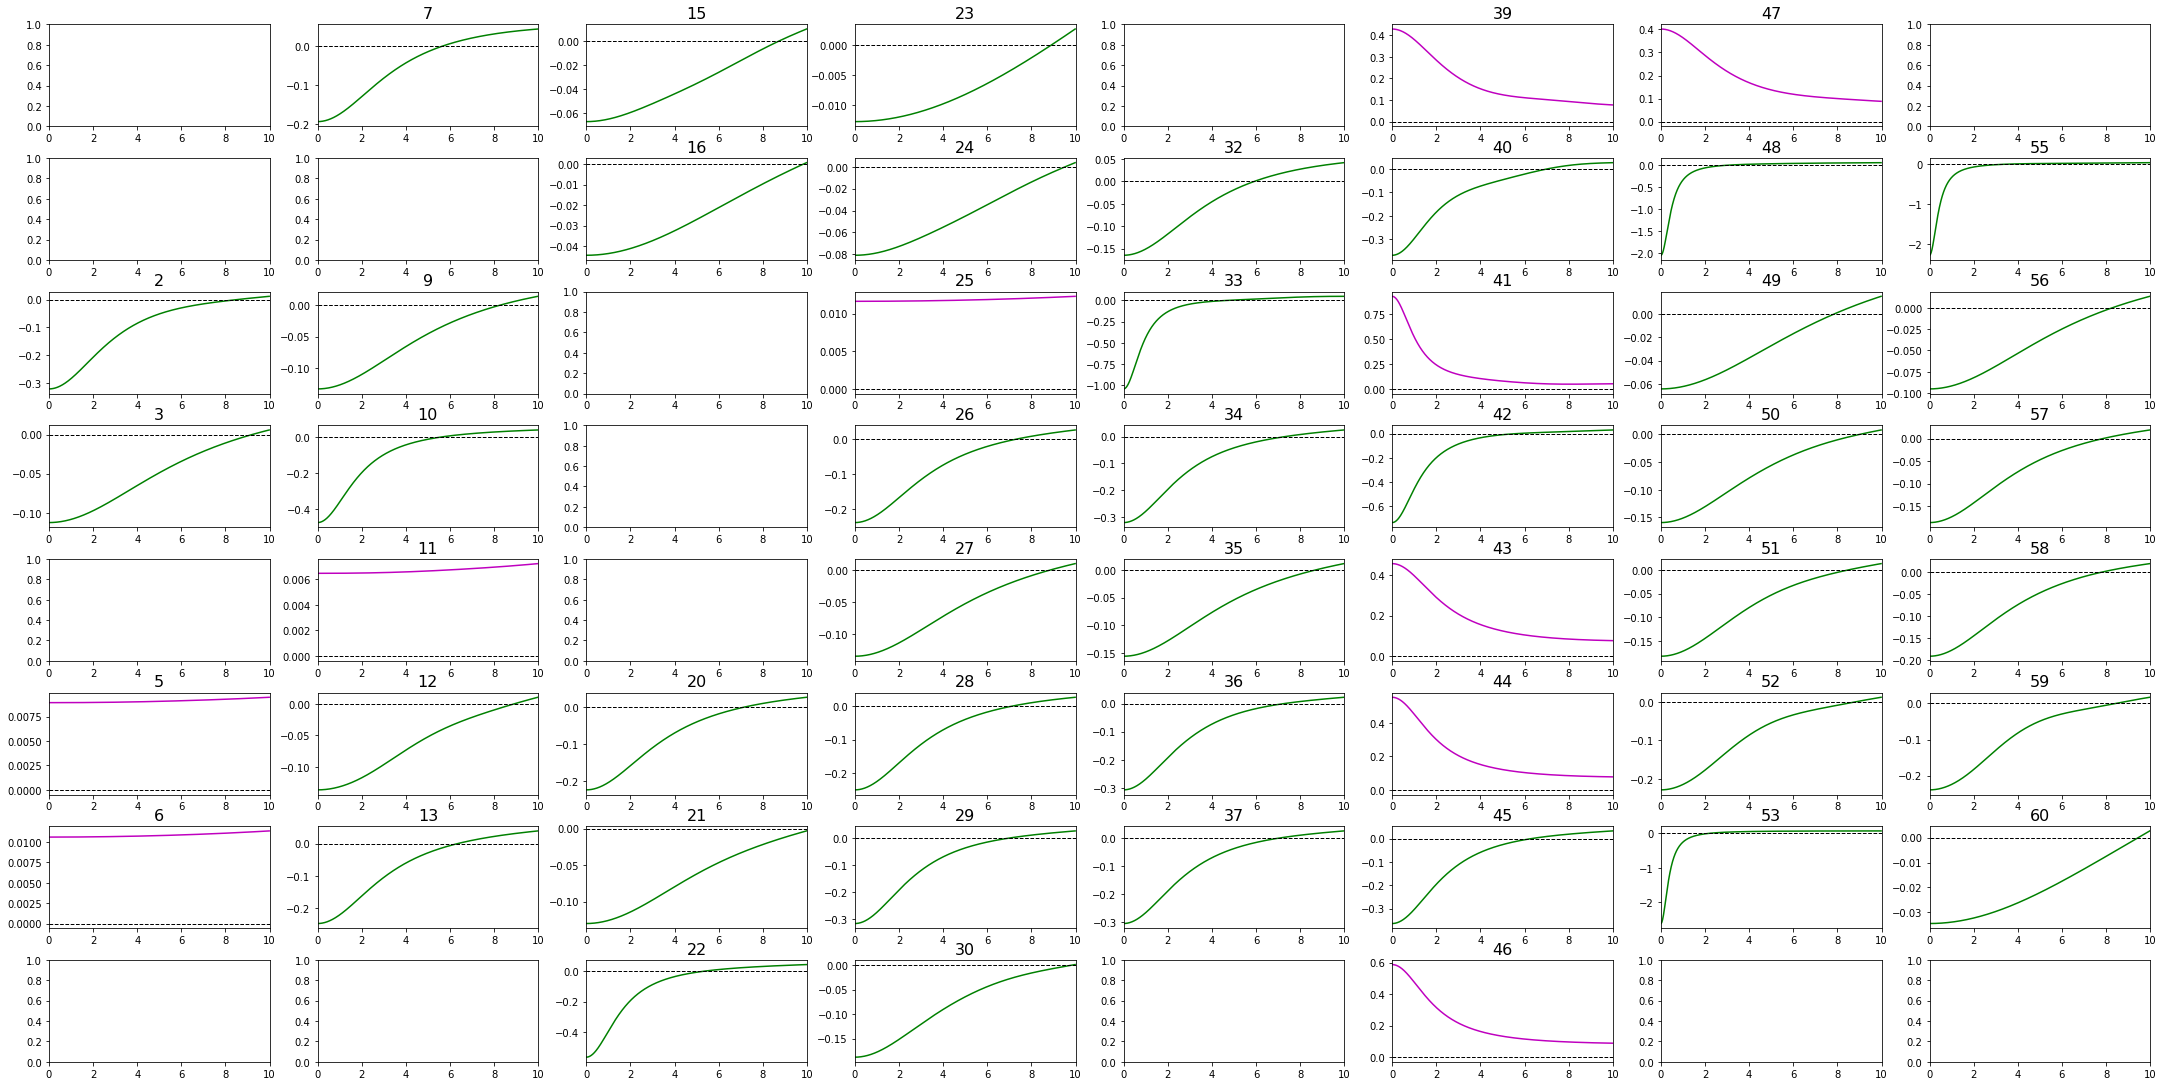

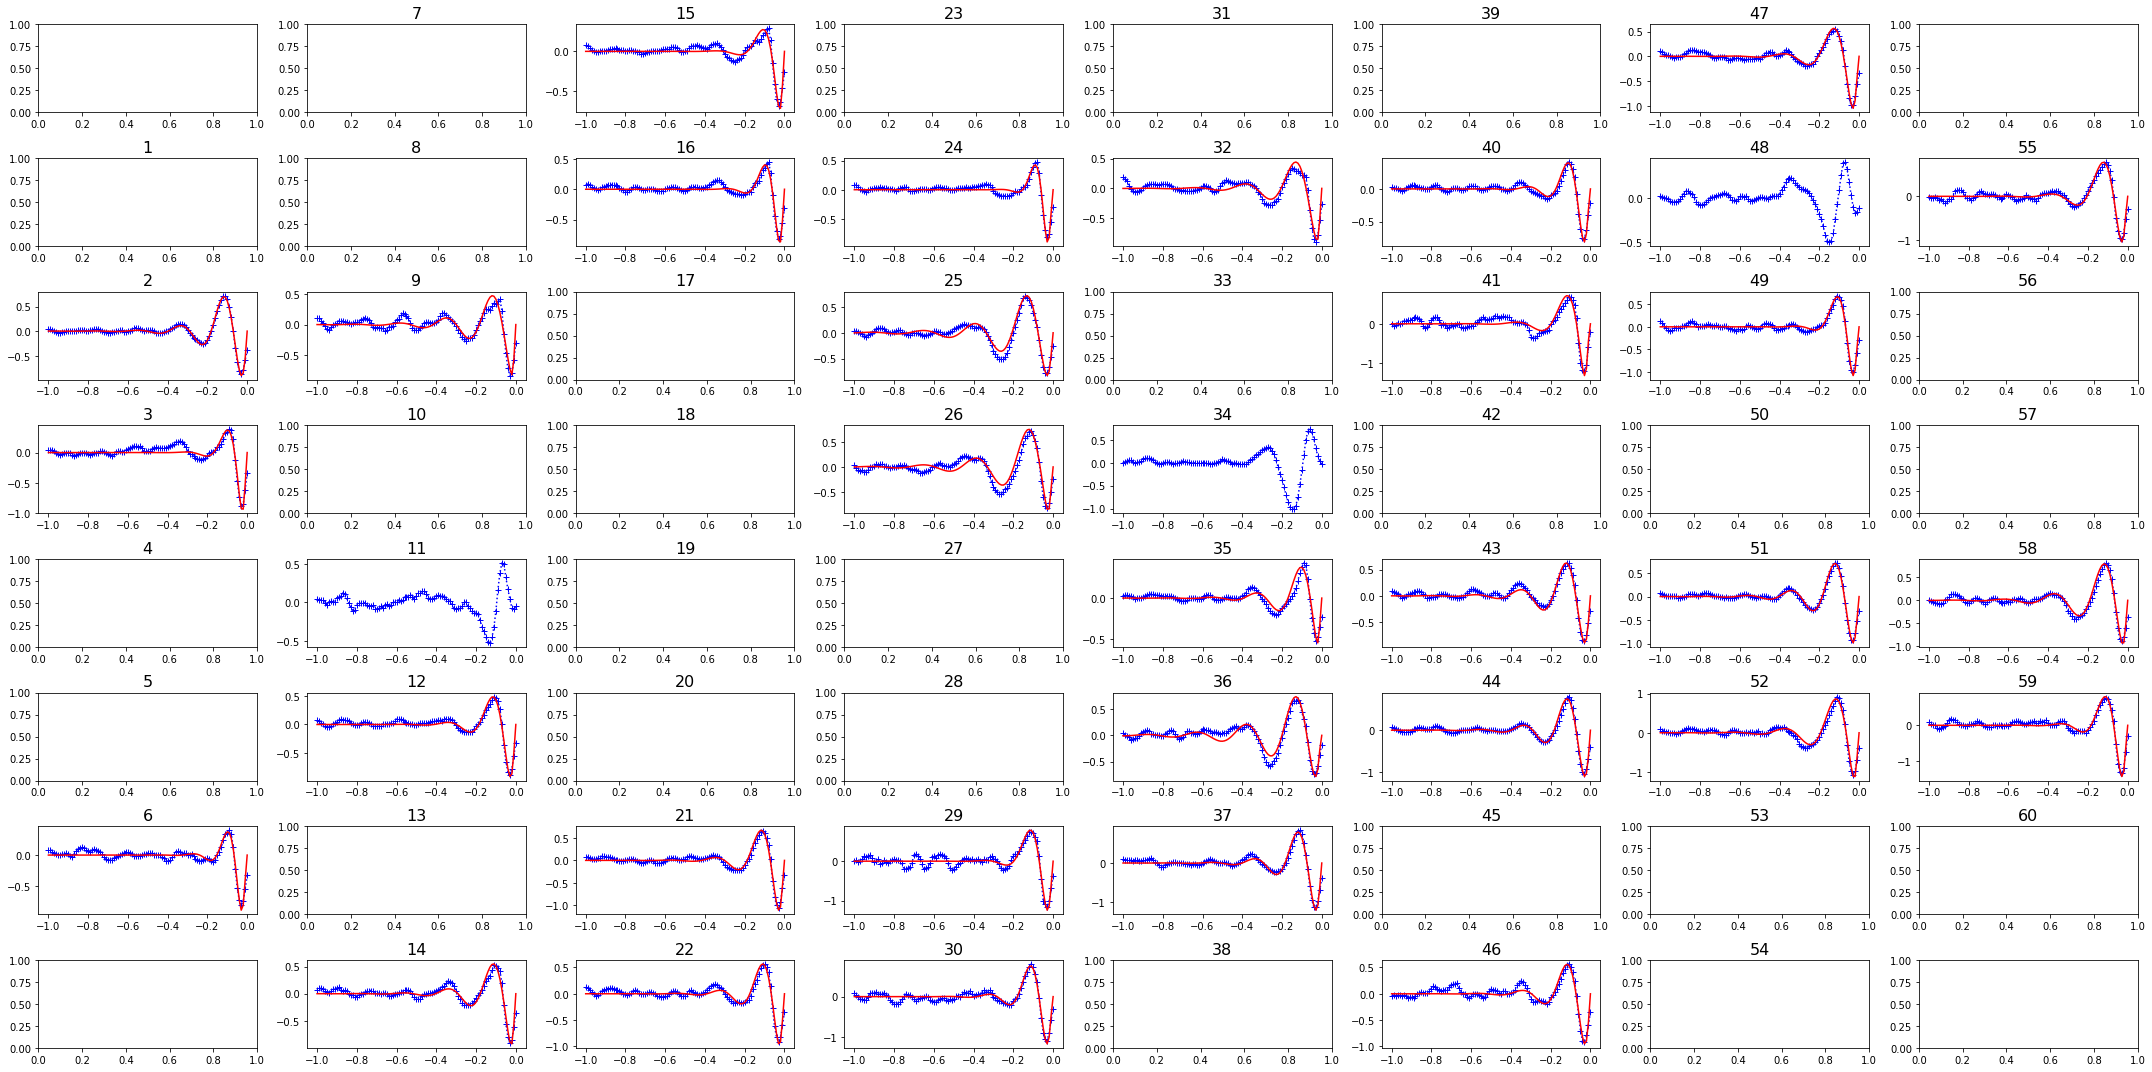

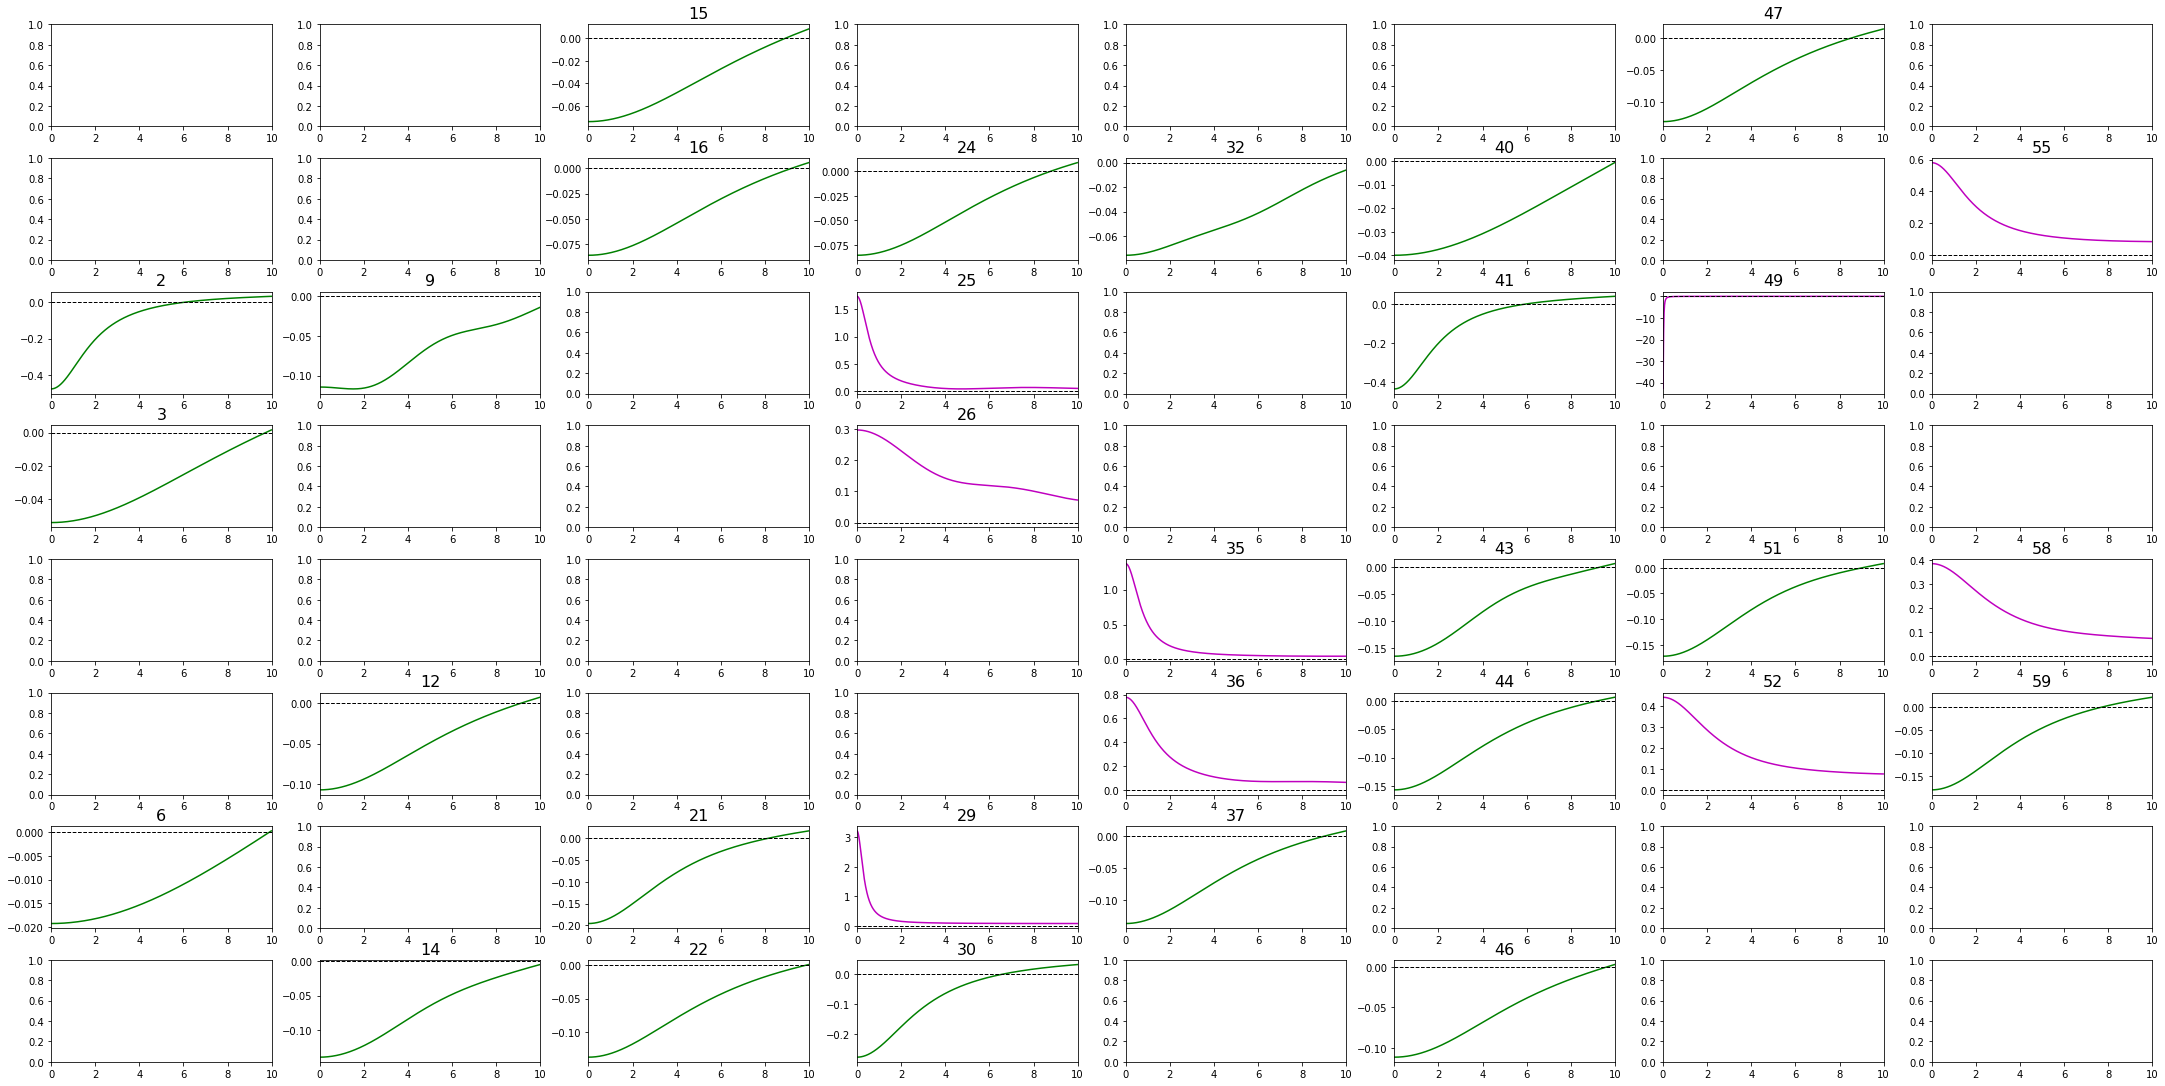

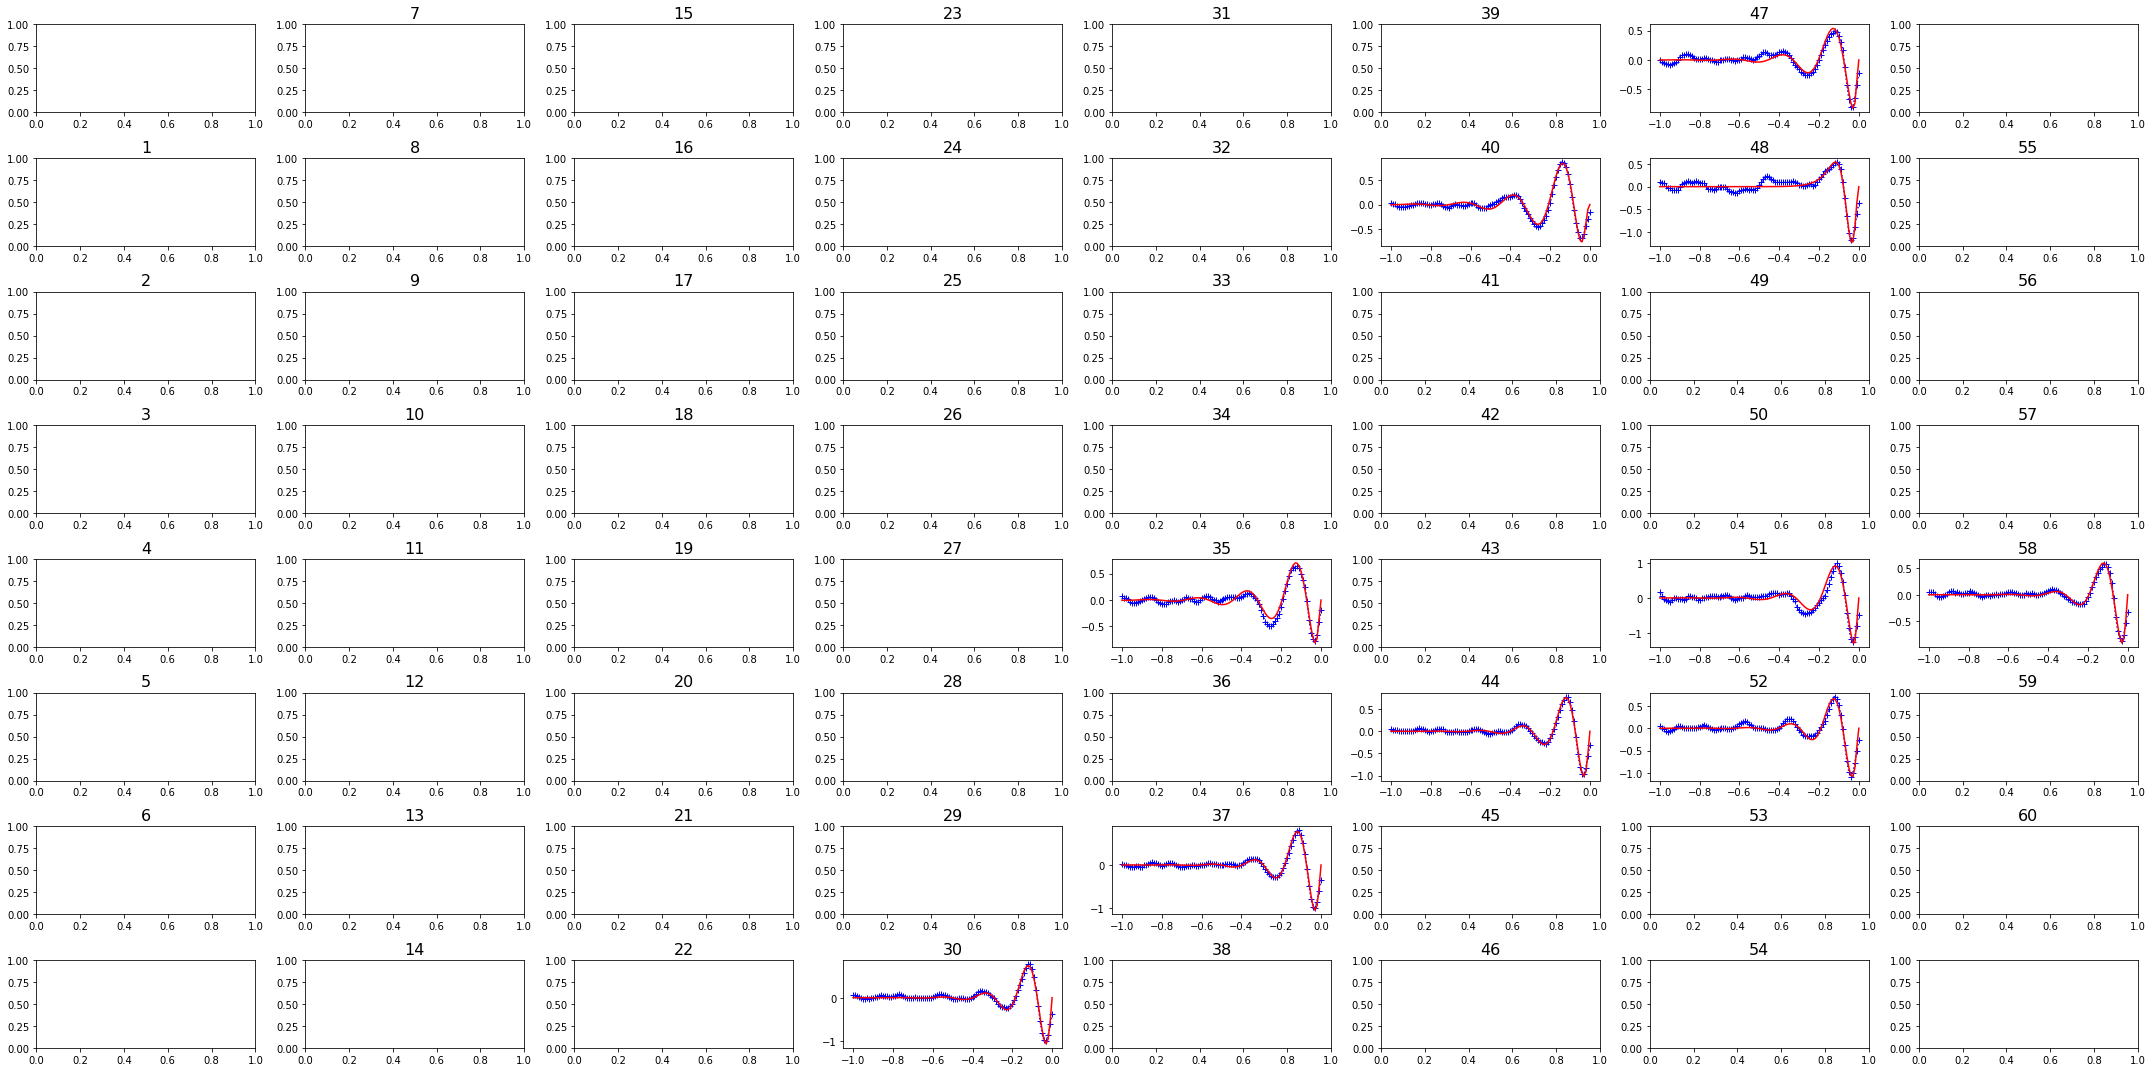

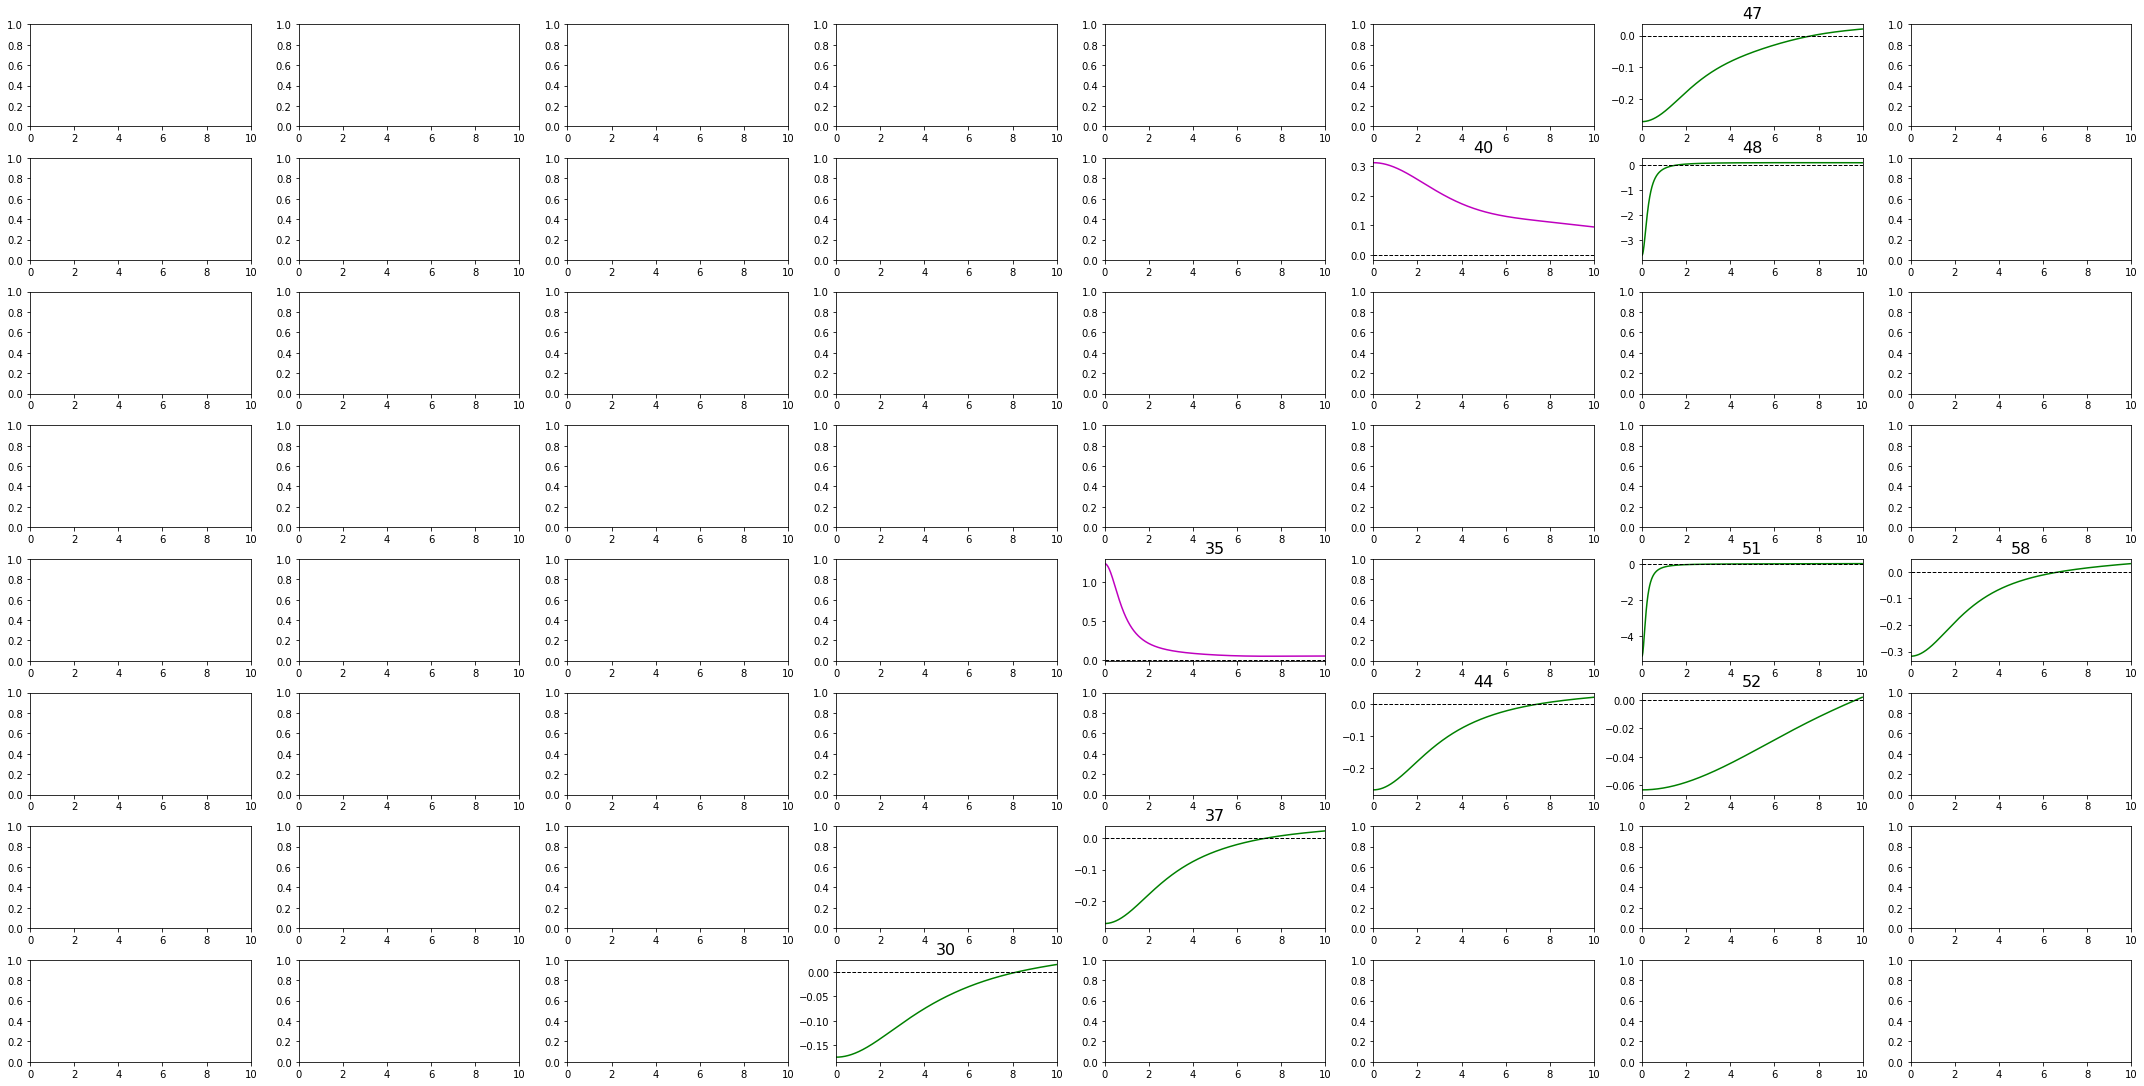

In [7]:
# for exp_date in ['0318', '0408', '0419', '0508', '0707']:
for exp_date in ['0408', '0419', '0508']:
    exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\2020'+exp_date
    ensure_dir(exp_folder+'\\TKfit')
    for filename in os.listdir(exp_folder):
        if filename.find('cSTA') != -1:
            dt = 0.01
            x_list, T_list, rstate_list = expSnR([exp_folder+'\\'+filename], dt, 'LED', np.arange(60)+1)
            x = x_list[0]
            x = x-np.mean(x)
            cSTA_list = [0]*60
            dcn = []
            fig, ax = plt.subplots(nrows=8, ncols=8)
            fig.set_size_inches(60, 30)
            for cn in range(60):
                rstate = rstate_list[0][cn,:]
                if sum(rstate) == 0: continue
                cSTA = np.correlate(x , rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
                cSTA = cSTA[int(len(cSTA)/2):int(len(cSTA)/2-1/dt)-1:-1]
                taxis = -np.arange(len(cSTA))*dt
                if (np.abs(cSTA[:round(len(cSTA)/2)]) < 7*np.std(cSTA[round(len(cSTA)/2):-1])).all(): continue
                if sum(cSTA[:8]) < -1: dcn.append(cn) # exclude fitting of On-cell
                ax[np.where(figmap == cn+1)][0].plot(taxis, cSTA, 'b+:')
                cSTA_list[cn] = cSTA

            name_list = ['epsilon', 'gamma', 'omegastar', 'deltastar', 'tau_y', 'Dmp']
            para_dict = {}
            for l in range(len(name_list)):
                para_dict[name_list[l]] = np.zeros(60)
            #-------------------------------------
            fit_cSTA_list = [0]*60
            para_dict['error'] = np.zeros(60)
            for cn in dcn.copy():
                epsilon = 10. #1/sec
                gamma = 25.
                omegastar = 30. 
                deltastar = 0.
                tau_y = 0.04
                Dmp = 10.
                try:
                    popt,pcov = curve_fit(NGD2L_TK_AS, np.abs(taxis), cSTA_list[cn], 
                                          p0     =  [epsilon, gamma , omegastar, deltastar, tau_y, Dmp   ],
                                          bounds = ([0      , 0     , 0        , -np.pi/2 , 0    , 0     ], 
                                                    [np.inf , np.inf, np.inf   ,  np.pi/2 , 0.1  , np.inf ] ))
                except:
                    dcn.remove(cn)
                    continue
                for l in range(len(popt)):
                    para_dict[name_list[l]][cn] = popt[l]
            #     print(popt)
                fit_cSTA_list[cn] = NGD2L_TK_AS(np.abs(taxis), *popt).copy()
                para_dict['error'][cn] = sum((fit_cSTA_list[cn]-cSTA_list[cn])**2)
                ax[np.where(figmap == cn+1)][0].plot(taxis, fit_cSTA_list[cn], 'r-')

            for cn in range(60):
                ax[np.where(figmap == cn+1)][0].set_title(str(cn+1), fontsize = 16)
            fig.set_size_inches(30, 15)
            fig.tight_layout()
            #-------------------------------------
            Dfig, Dax = plt.subplots(nrows=8, ncols=8)
            Dfig.set_size_inches(30, 15)
            Dfig.tight_layout()
            pcn = []
            ncn = []
            for cn in dcn:
                #constrani 1
                if sum(rstate_list[0][cn])/180 < 0.3: continue
                domega = 0.01
                omega = np.arange(-1,10,domega) #limited by [pi/dt,pi/dt)
                TKdw = np.sum(fit_cSTA_list[cn][np.newaxis,:]*np.exp(-1j*np.abs(taxis[np.newaxis,:])*omega[:,np.newaxis]), axis = 1)*dt
                phi = np.angle(TKdw)
                delta = -angular_gradient(phi)/domega
                Dax[np.where(figmap == cn+1)][0].set_title(str(cn+1), fontsize = 16)

                #constrani 2
                if delta[0] < 0: 
                    pcn.append(cn)
                    Dax[np.where(figmap == cn+1)][0].plot(omega[:-1], delta[:-1], 'g')
                else: 
                    ncn.append(cn)
                    Dax[np.where(figmap == cn+1)][0].plot(omega[:-1], delta[:-1], 'm')

            for Daxy in Dax:
                for ax in Daxy:
                    ax.axhline(0,linewidth=1, linestyle='--', c='k')
                    ax.set_xlim([0,10])
            #-------------------------------------
            un = filename[filename.find('unit'):filename.find('unit')+5]
            if XOsave:
                Dfig.set_size_inches(50, 25)
                Dfig.tight_layout()
                Dfig.savefig(exp_folder+'\\TKfit\\'+un+'_NGD2LAS_GroupDelay.tiff', bbox_inches = 'tight',pad_inches = 0.3)
                np.savez(exp_folder+'\\TKfit\\'+un+'_fitNGD2LASpara.npz', para_dict=para_dict, pcn=pcn, ncn=ncn)
                fig.set_size_inches(50, 25)
                fig.tight_layout()
                fig.savefig(exp_folder+'\\TKfit\\'+un+'_fitNGD2LASparameter.tiff', bbox_inches = 'tight',pad_inches = 0.3)